In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

## Download Stock Data

In [2]:
import threading

date = '2019-05-31'
ticker_request_case_study = ['TDOC','WD','KNSL','BOMN','APPN']
ticker_request_yahoo_top30 = ['AAPL','MSFT','GOOG','AMZN','FB','TSLA','NVDA','DIS','NVO','AMD','ABNB','GM','NIO','F','RBLX','CRWD','DOCU','BIIB','NOK','AMC','GME','UPST','PSFE','TLRY','BB','PSTH','CLOV','BBBY','MVIS','SAML']
ticker_request_motley_fool_top30 = ['BTC','CMPS','CSTL','CURI','DCBO','GSHD','OM','UPST','CALT','DAVA','FLGT','FTHM','LMND','PUBM','SPT','TTCF','AVIR','BIGC','CELH','DOCN','FVRR','INMD','RETA','SMLR','YALA','AMWL','BTRS','DMTK','FROG','KOD','PGNY','POSH','SKLZ','RWM','VINP']
tickers = []
stocks = {}

def downloadStocks(ticker, date):
    try:
        stocks[ticker] = pdr.get_data_yahoo(ticker,date)
        stocks[ticker].drop('Adj Close', axis=1, inplace=True)
        stocks[ticker].drop('High', axis=1, inplace=True)
        stocks[ticker].drop('Low', axis=1, inplace=True)
        stocks[ticker].drop('Open', axis=1, inplace=True)
        stocks[ticker].drop('Volume', axis=1, inplace=True)
        tickers.append(ticker)
    except:
        print("Failed to get %s" % ticker)

threads = []

for ticker in ticker_request_yahoo_top30:
    ticker_thread = threading.Thread(target=downloadStocks, args=(ticker, date,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

print(tickers)
stocks[tickers[0]].head()

['PSFE', 'RBLX', 'FB', 'PSTH', 'AMZN', 'ABNB', 'MVIS', 'MSFT', 'NOK', 'TSLA', 'UPST', 'BB', 'GM', 'GOOG', 'SAML', 'NVO', 'NVDA', 'AMD', 'F', 'NIO', 'TLRY', 'CRWD', 'DIS', 'BIIB', 'GME', 'DOCU', 'AMC', 'CLOV', 'AAPL', 'BBBY']


Close
Date             
2020-10-09  9.950
2020-10-12  9.860
2020-10-13  9.900
2020-10-14  9.860
2020-10-15  9.805

## Generate Baseline Performance and Moving Average (MA) Performance

In [3]:
def generateSystems(ticker):
    stocks[ticker]['3-day'] = stocks[ticker]['Close'].rolling(3).mean()
    stocks[ticker]['9-day'] = stocks[ticker]['Close'].rolling(9).mean()
    stocks[ticker]['21-day'] = stocks[ticker]['Close'].rolling(21).mean()
    stocks[ticker]['Change'] = (stocks[ticker].Close-stocks[ticker].Close.shift())/stocks[ticker].Close.shift()
    
    # When the faster moving average is moving above the slower one, indicates time to buy
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] > stocks[ticker]['9-day'], 1,0)
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] > stocks[ticker]['21-day'], 1,0)
    # When the faster moving average is moving below the slower one, indicates time to sell
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] < stocks[ticker]['9-day'],-1,stocks[ticker]['position-3-9'])
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] < stocks[ticker]['21-day'],-1,stocks[ticker]['position-9-21'])
    
    # Whether we are making money with this system
    stocks[ticker]['system-3-9'] = np.where(stocks[ticker]['position-3-9'] > 0, stocks[ticker]['position-3-9']* stocks[ticker]['Change'],0)
    stocks[ticker]['system-9-21'] = np.where(stocks[ticker]['position-9-21'] > 0, stocks[ticker]['position-9-21']* stocks[ticker]['Change'],0)

    stocks[ticker]['Volatility'] = stocks[ticker].Change.rolling(21).std().shift()
    
threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

Close      3-day      9-day     21-day    Change  position-3-9  \
Date                                                                         
2021-06-02  12.15  11.723333  11.688889  11.965714  0.029661             1   
2021-06-03  11.82  11.923333  11.661111  11.881429 -0.027160             1   
2021-06-04  12.26  12.076667  11.694444  11.832381  0.037225             1   
2021-06-07  12.30  12.126667  11.767778  11.810476  0.003263             1   
2021-06-08  12.08  12.213333  11.832222  11.745238 -0.017886             1   

            position-9-21  system-3-9  system-9-21  Volatility  
Date                                                            
2021-06-02             -1    0.029661     0.000000    0.045638  
2021-06-03             -1   -0.027160     0.000000    0.046231  
2021-06-04             -1    0.037225     0.000000    0.046333  
2021-06-07             -1    0.003263     0.000000    0.047078  
2021-06-08              1   -0.017886    -0.017886    0.046312

## Generate DGIM MA Performance

In [4]:
%reload_ext autoreload
%autoreload 2
from ipynb.fs.full.DGIMMovingAverage import *
import threading

bit_depth = 16
num_buckets = 5

def generateDGIMSystems(ticker):
    stocks_list = stocks[ticker]['Close'].tolist()
    stocks_3day_list = stocks[ticker]['3-day'].tolist()
    stocks_9day_list = stocks[ticker]['9-day'].tolist()
    stocks_21day_list = stocks[ticker]['21-day'].tolist()
    stocks_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in stocks_list ]

    try:
        dgim_3day = DGIMMovingAverage(stocks_list_bin, 3, num_buckets, bit_depth, stocks_3day_list, True)
        stocks[ticker]['3-day-dgim'] = dgim_3day.mov_avg
        dgim_9day = DGIMMovingAverage(stocks_list_bin, 9, num_buckets, bit_depth, stocks_9day_list, True)
        stocks[ticker]['9-day-dgim'] = dgim_9day.mov_avg
        dgim_21day = DGIMMovingAverage(stocks_list_bin, 21, num_buckets, bit_depth, stocks_21day_list, True)
        stocks[ticker]['21-day-dgim'] = dgim_21day.mov_avg

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] > stocks[ticker]['9-day-dgim'], 1,0)
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] > stocks[ticker]['21-day-dgim'], 1,0)

        # When the faster moving average is moving below the slower one, indicates time to sell\
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] < stocks[ticker]['9-day-dgim'],-1,stocks[ticker]['position-dgim-3-9'])
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] < stocks[ticker]['21-day-dgim'],-1,stocks[ticker]['position-dgim-9-21'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9'] = np.where(stocks[ticker]['position-dgim-3-9'] > 0, stocks[ticker]['position-dgim-3-9']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21'] = np.where(stocks[ticker]['position-dgim-9-21'] > 0, stocks[ticker]['position-dgim-9-21']* stocks[ticker]['Change'],0)
        
    except Exception as e:
        print("Failed to analyze %s" % ticker, e)
        tickers.remove(ticker)

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateDGIMSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## Generate Normalized DGIM MA Performance

In [5]:
def normalizeDGIM(ticker):
    try:
        stocks[ticker]['3-day-dgim-norm']=(stocks[ticker]['3-day-dgim']-stocks[ticker]['3-day-dgim'].mean())/stocks[ticker]['3-day-dgim'].std()
        stocks[ticker]['9-day-dgim-norm']=(stocks[ticker]['9-day-dgim']-stocks[ticker]['9-day-dgim'].mean())/stocks[ticker]['9-day-dgim'].std()
        stocks[ticker]['21-day-dgim-norm']=(stocks[ticker]['21-day-dgim']-stocks[ticker]['21-day-dgim'].mean())/stocks[ticker]['21-day-dgim'].std()

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] > stocks[ticker]['9-day-dgim-norm'], 1,0)
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] > stocks[ticker]['21-day-dgim-norm'], 1,0)
        # When the faster moving average is moving below the slower one, indicates time to sell
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] < stocks[ticker]['9-day-dgim-norm'],-1,stocks[ticker]['position-dgim-3-9-norm'])
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] < stocks[ticker]['21-day-dgim-norm'],-1,stocks[ticker]['position-dgim-9-21-norm'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9-norm'] = np.where(stocks[ticker]['position-dgim-3-9-norm'] > 0, stocks[ticker]['position-dgim-3-9-norm']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21-norm'] = np.where(stocks[ticker]['position-dgim-9-21-norm'] > 0, stocks[ticker]['position-dgim-9-21-norm']* stocks[ticker]['Change'],0)
    except:
        pass

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=normalizeDGIM, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

Close      3-day      9-day     21-day    Change  position-3-9  \
Date                                                                         
2021-06-02  12.15  11.723333  11.688889  11.965714  0.029661             1   
2021-06-03  11.82  11.923333  11.661111  11.881429 -0.027160             1   
2021-06-04  12.26  12.076667  11.694444  11.832381  0.037225             1   
2021-06-07  12.30  12.126667  11.767778  11.810476  0.003263             1   
2021-06-08  12.08  12.213333  11.832222  11.745238 -0.017886             1   

            position-9-21  system-3-9  system-9-21  Volatility  ...  \
Date                                                            ...   
2021-06-02             -1    0.029661     0.000000    0.045638  ...   
2021-06-03             -1   -0.027160     0.000000    0.046231  ...   
2021-06-04             -1    0.037225     0.000000    0.046333  ...   
2021-06-07             -1    0.003263     0.000000    0.047078  ...   
2021-06-08              1   -0.017886    -0.017886    0.046312  ...   

            position-dgim-9-21  system-dgim-3-9  system-dgim-9-21  \
Date                                                                
2021-06-02                  -1              0.0               0.0   
2021-06-03                  -1              0.0               0.0   
2021-06-04                  -1              0.0               0.0   
2021-06-07                  -1              0.0               0.0   
2021-06-08                  -1              0.0               0.0   

            3-day-dgim-norm  9-day-dgim-norm  21-day-dgim-norm  \
Date                                                             
2021-06-02        -0.337783        -0.808907         -0.945694   
2021-06-03        -0.694533        -0.808907         -0.999692   
2021-06-04        -0.694533        -0.808907         -1.026690   
2021-06-07        -0.694533        -0.808907         -1.026690   
2021-06-08        -0.694533        -0.808907         -1.053689   

            position-dgim-3-9-norm  position-dgim-9-21-norm  \
Date                                                          
2021-06-02                       1                        1   
2021-06-03                       1                        1   
2021-06-04                       1                        1   
2021-06-07                       1                        1   
2021-06-08                       1                        1   

            system-dgim-3-9-norm  system-dgim-9-21-norm  
Date                                                     
2021-06-02              0.029661               0.029661  
2021-06-03             -0.027160              -0.027160  
2021-06-04              0.037225               0.037225  
2021-06-07              0.003263               0.003263  
2021-06-08             -0.017886              -0.017886  

[5 rows x 24 columns]

## View Individual Stocks DGIM/Normalized DGIM MA vs. Baseline and MA Performance

/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 fi

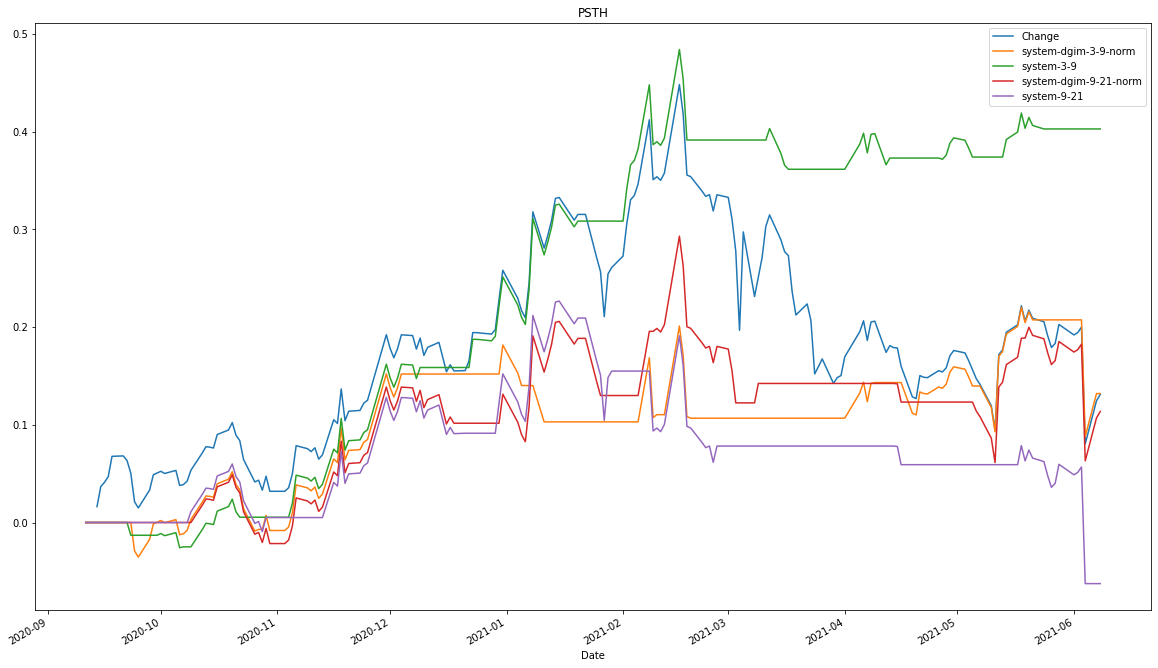

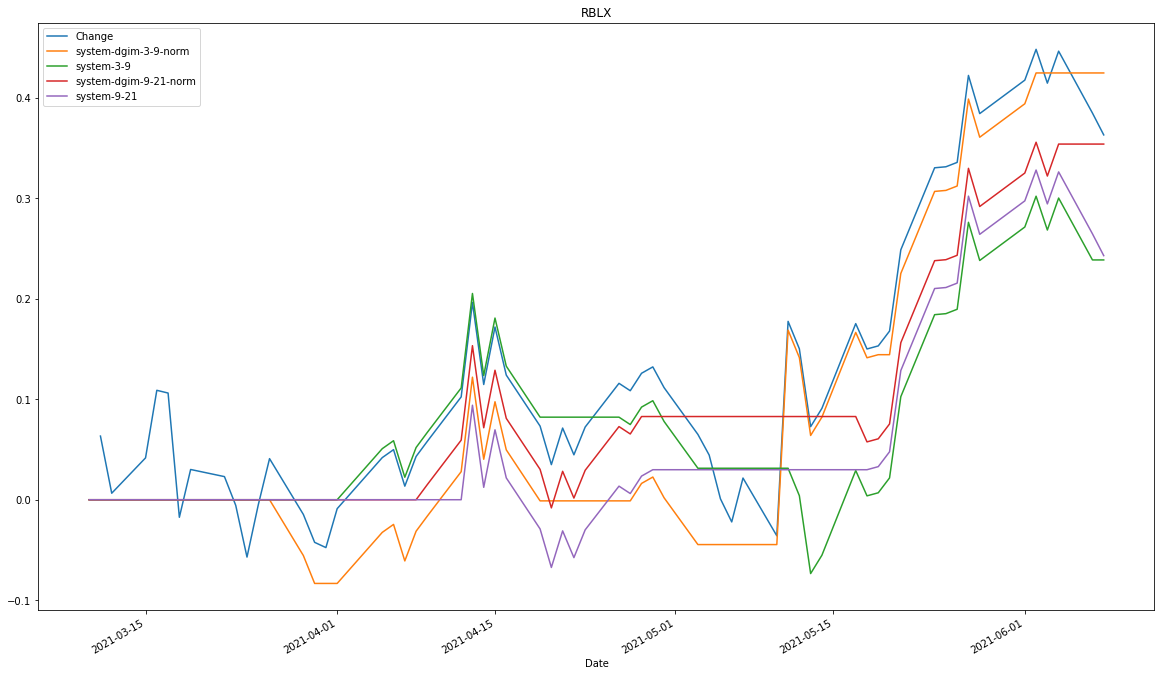

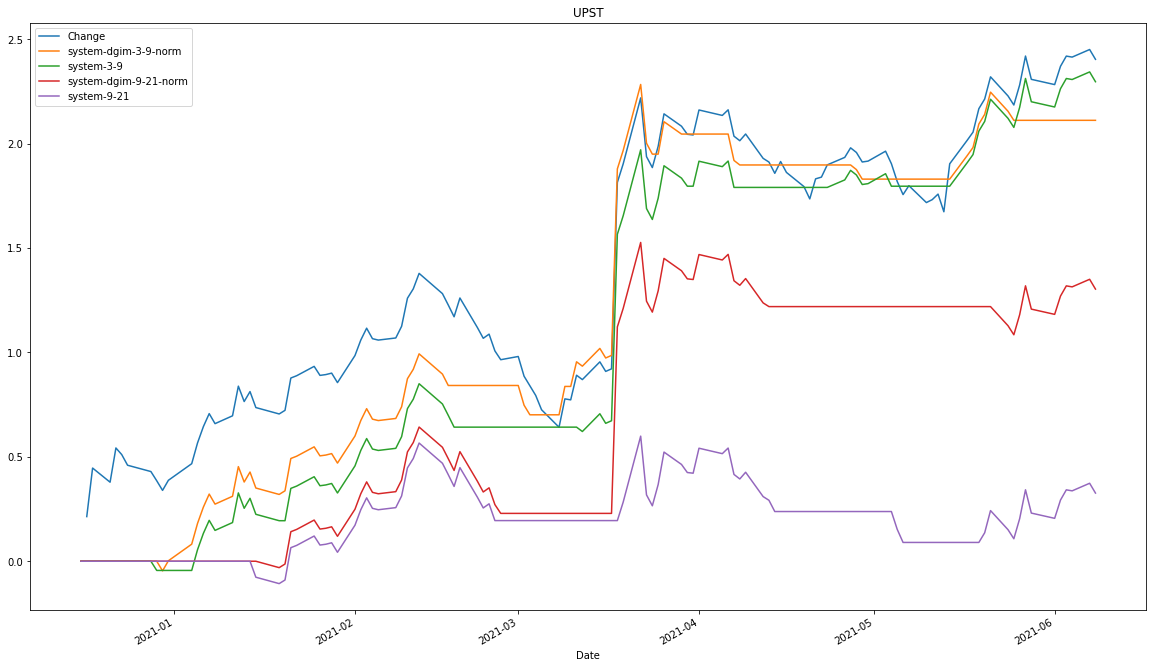

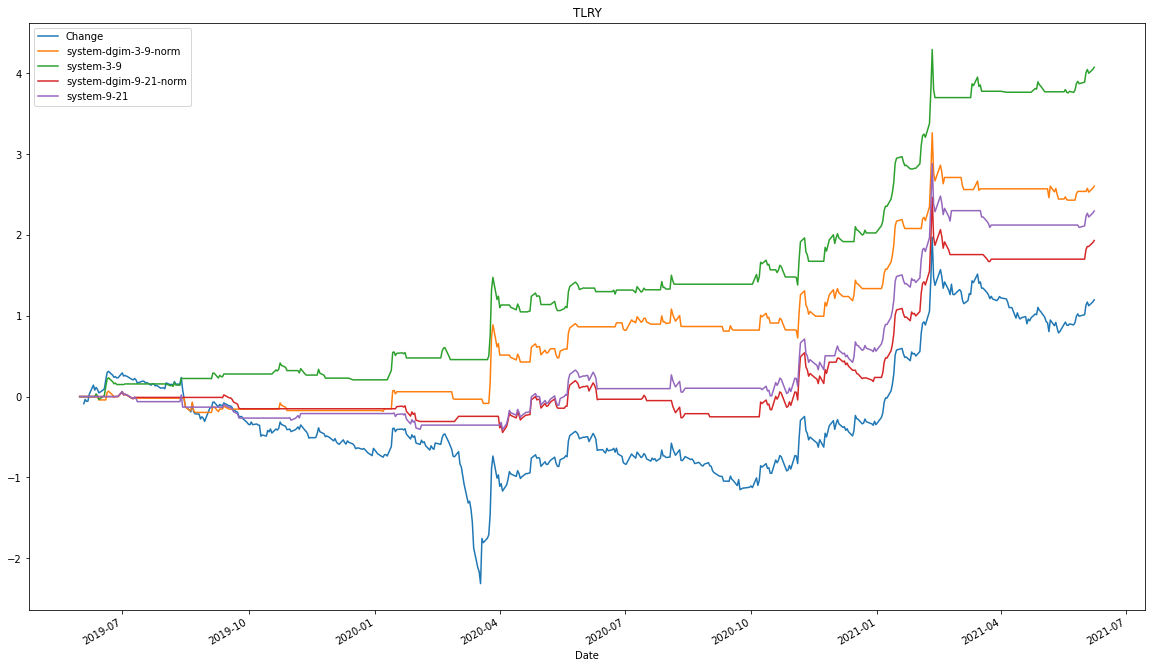

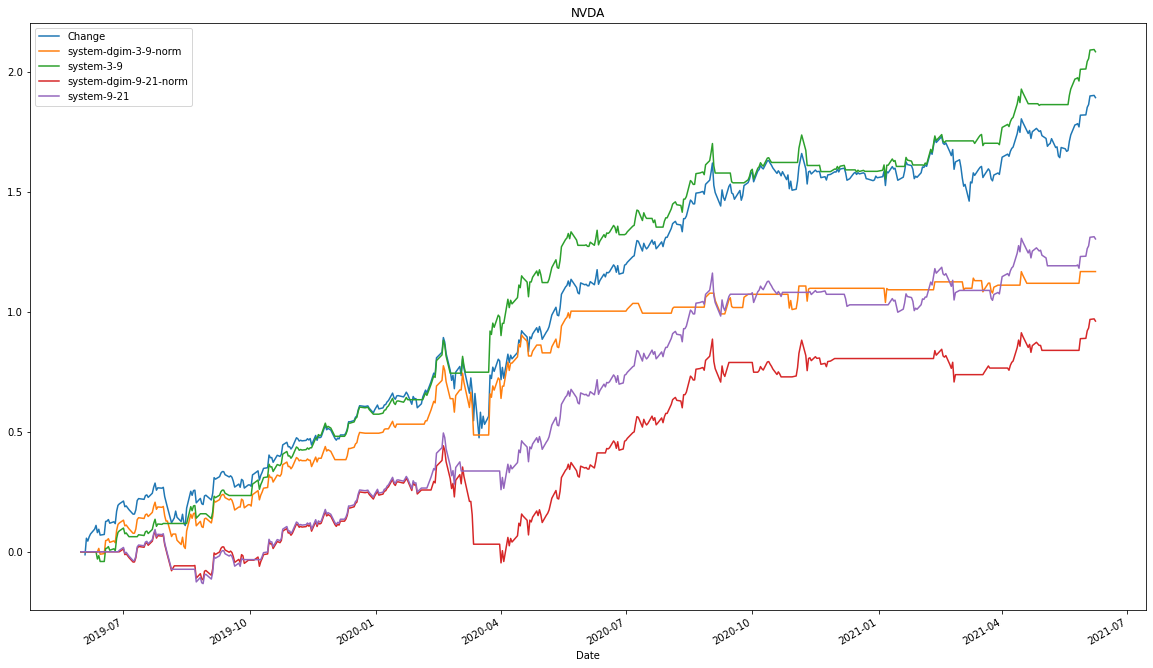

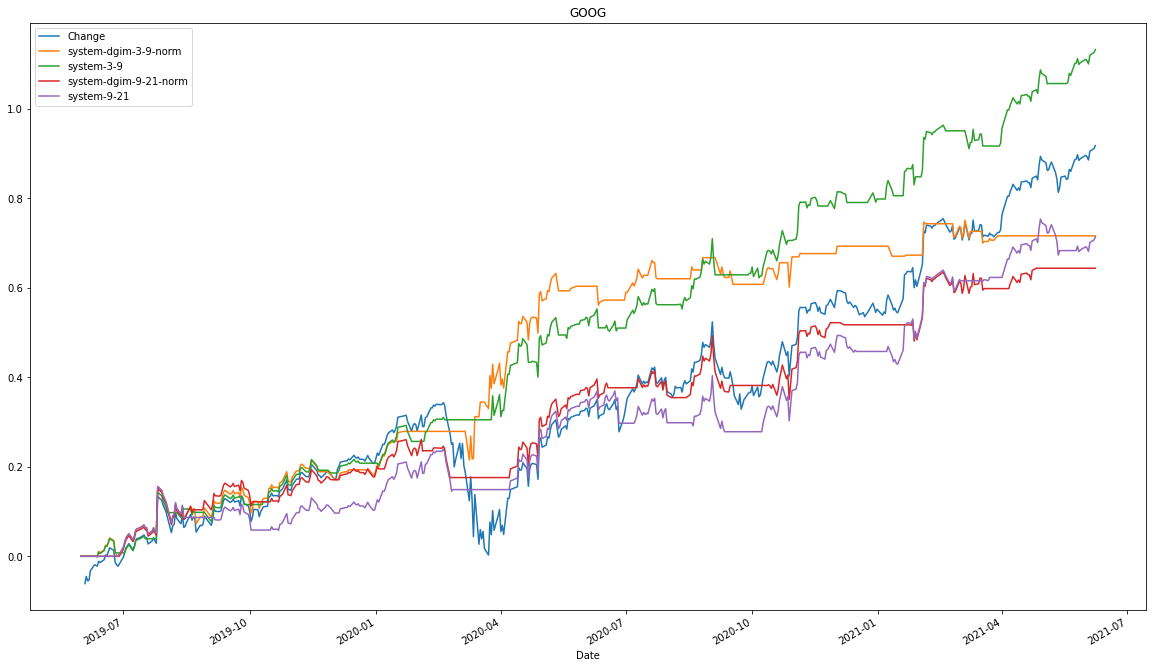

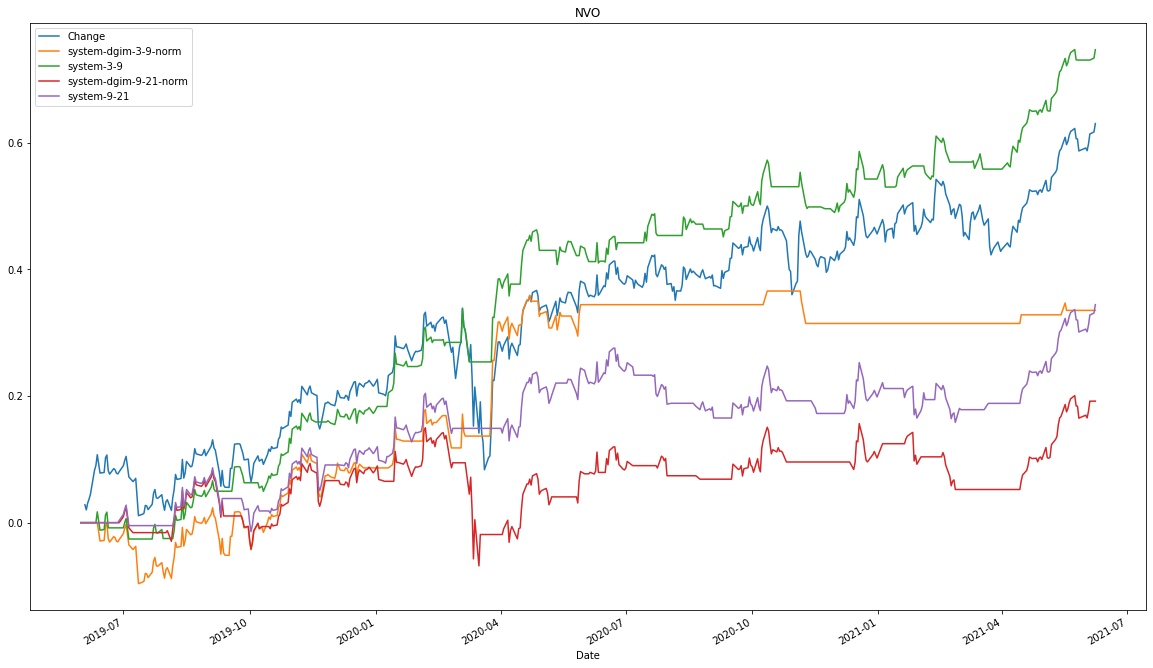

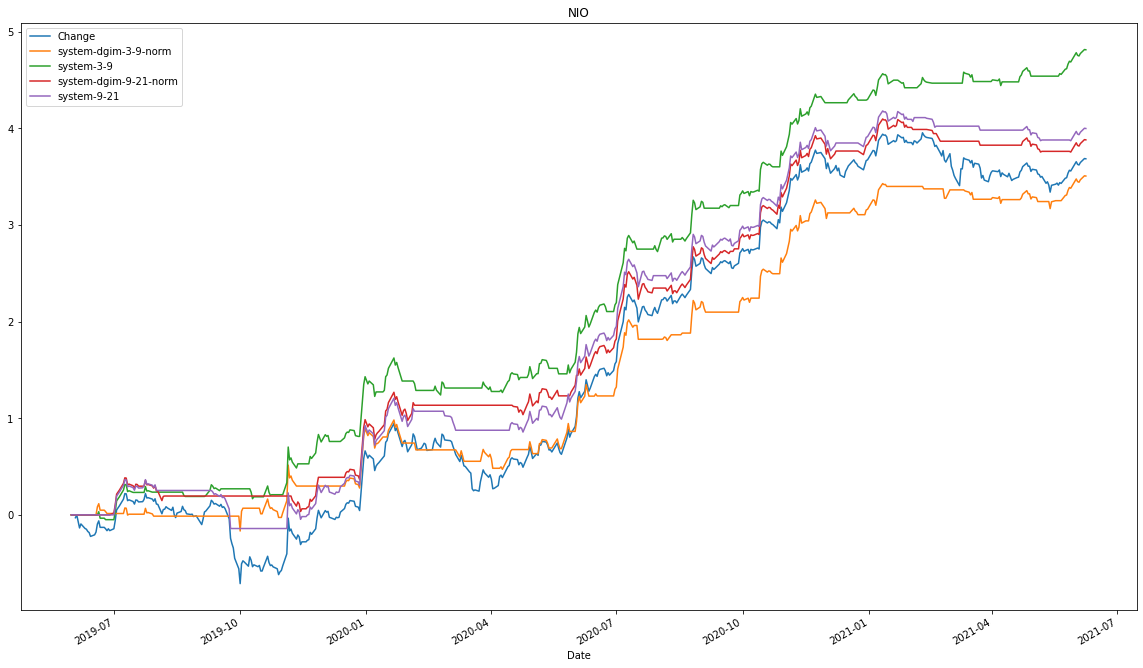

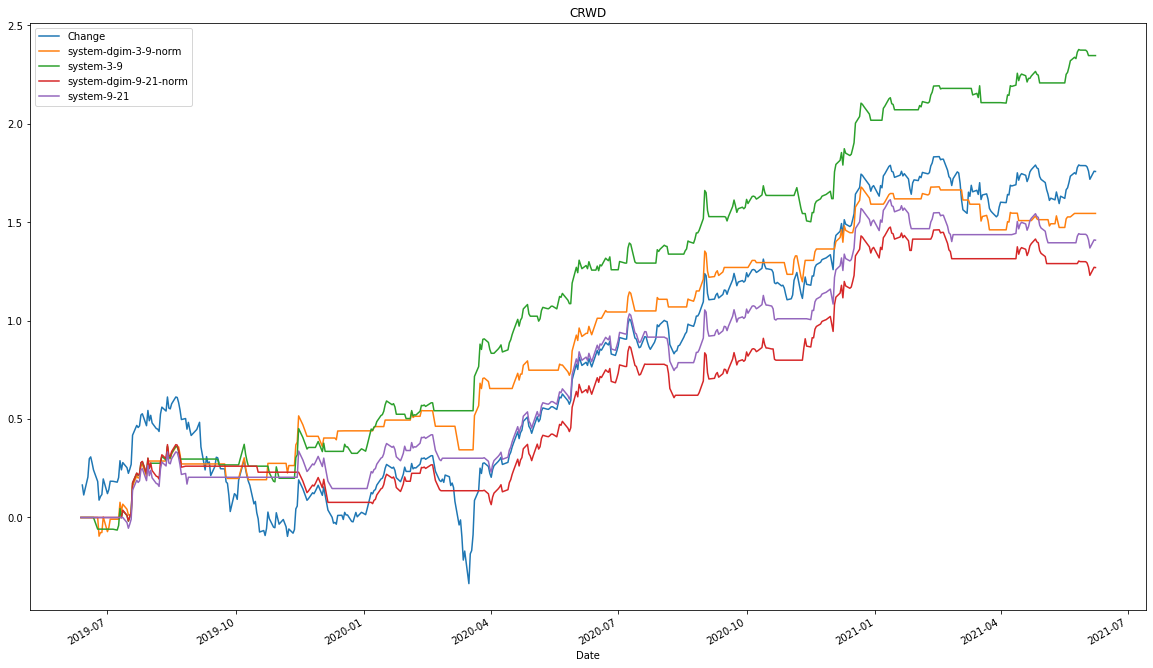

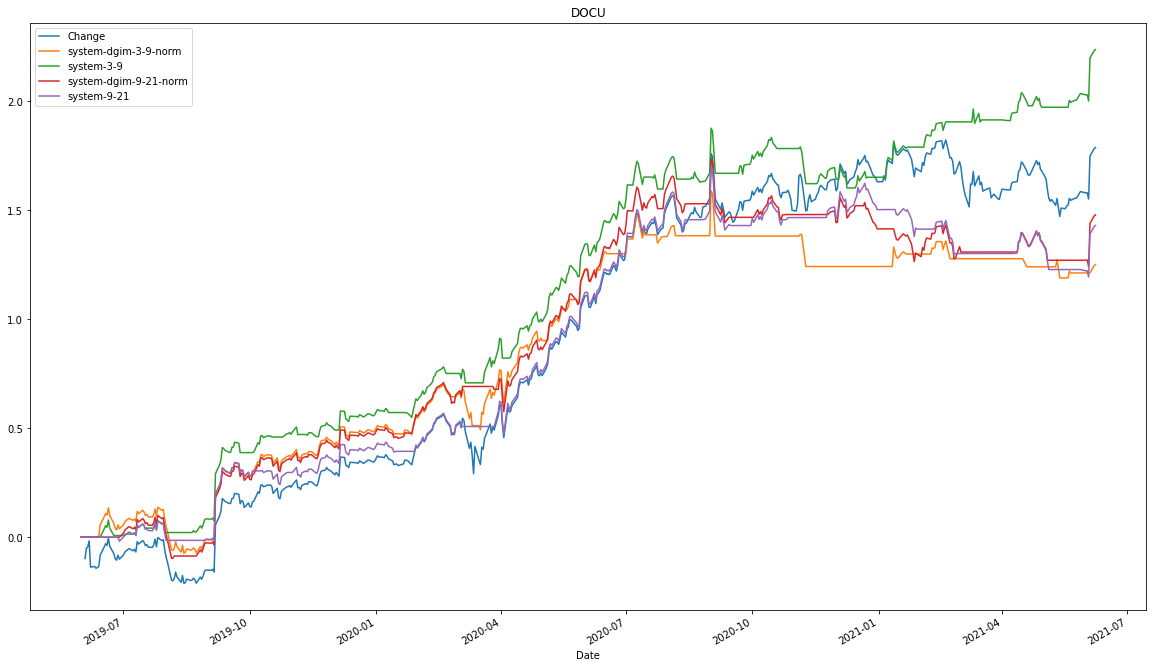

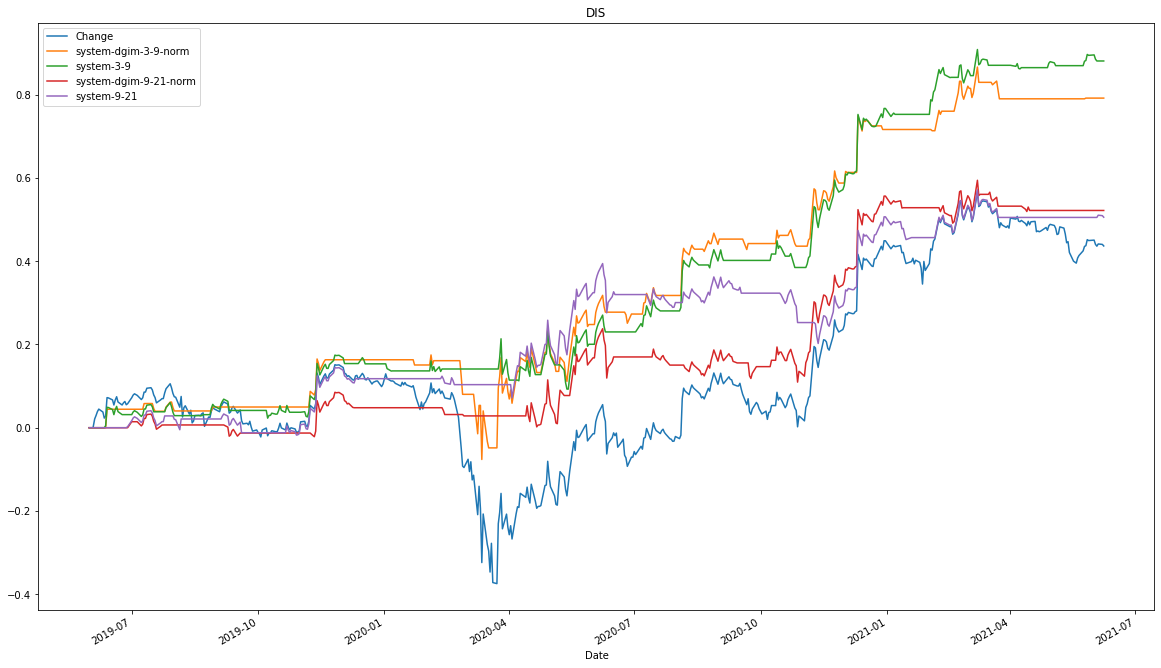

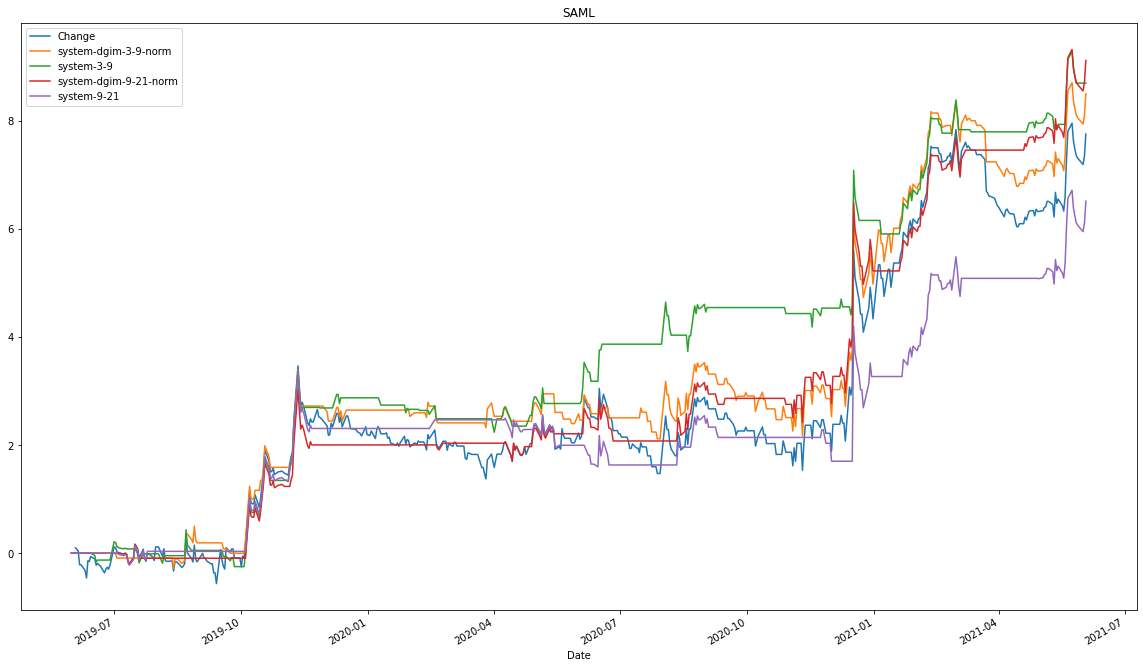

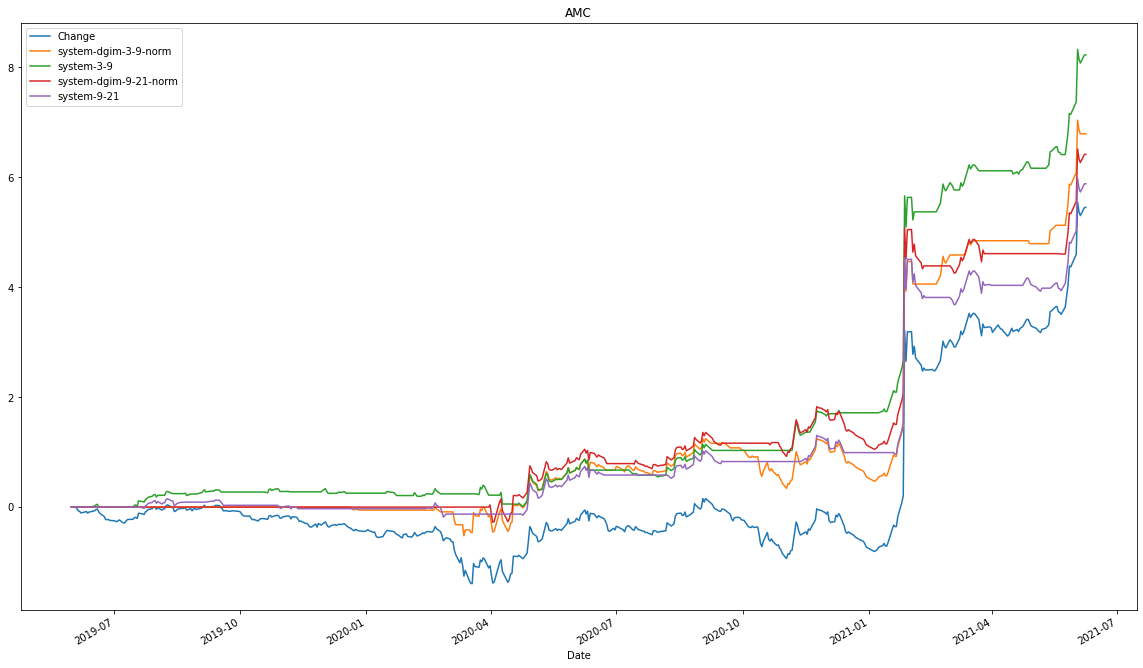

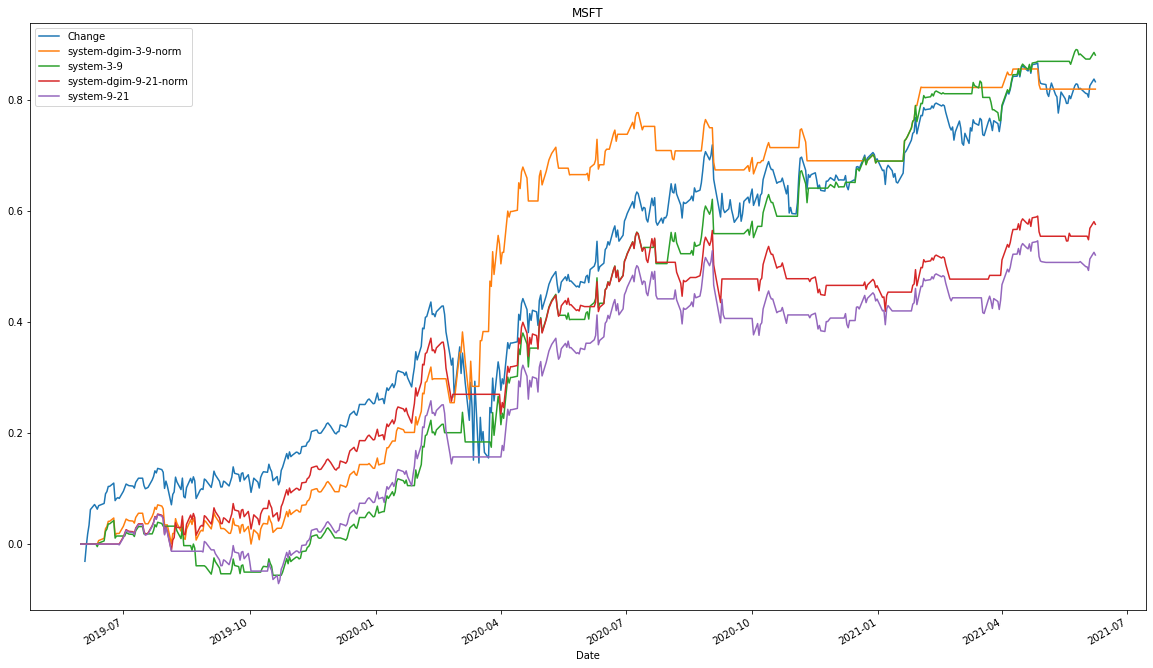

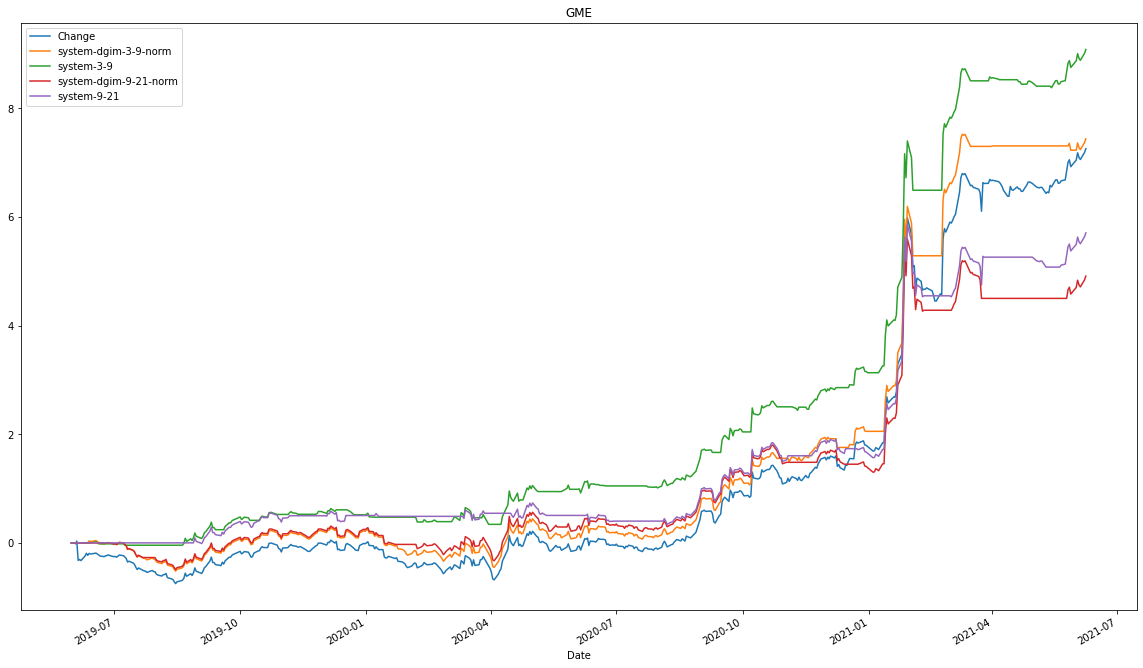

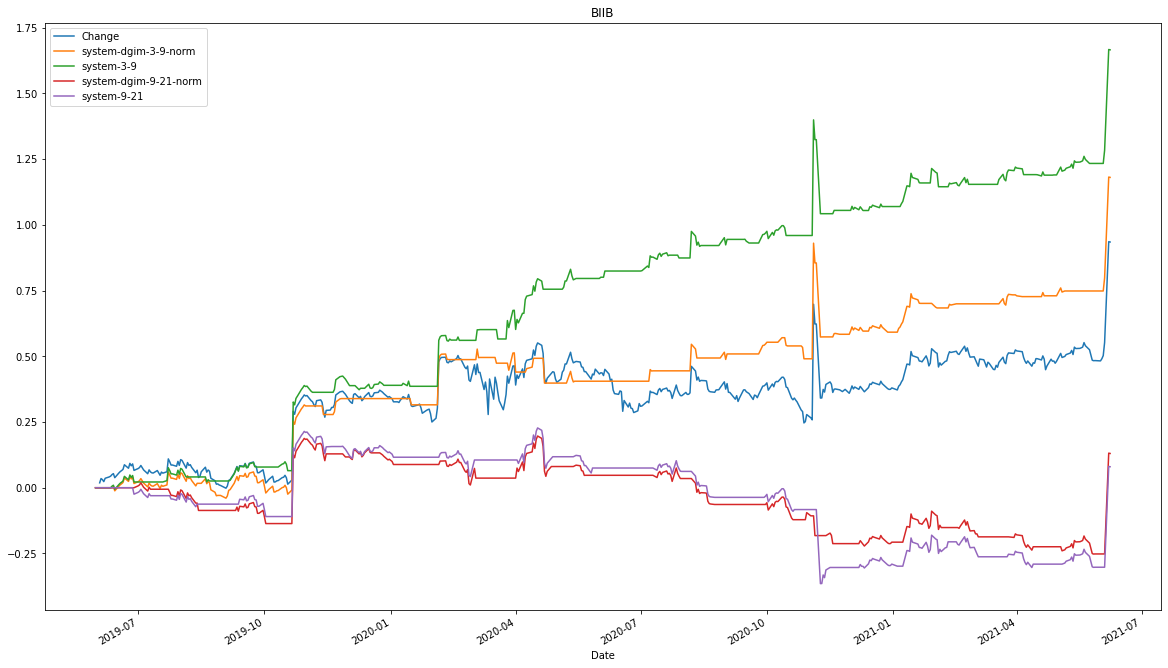

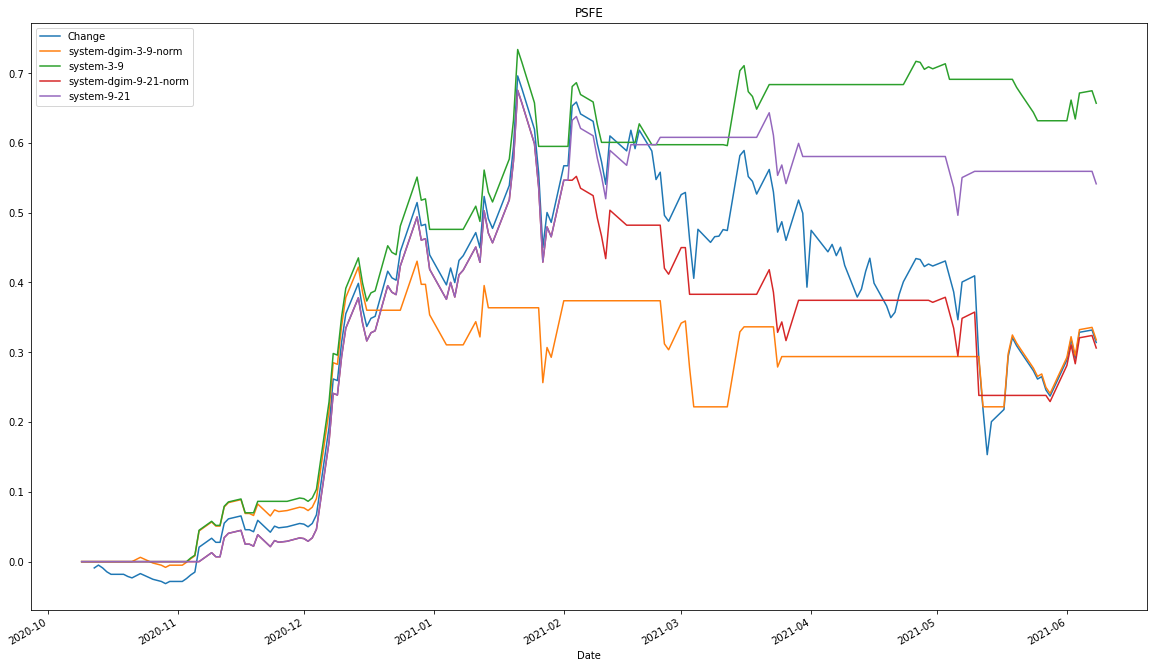

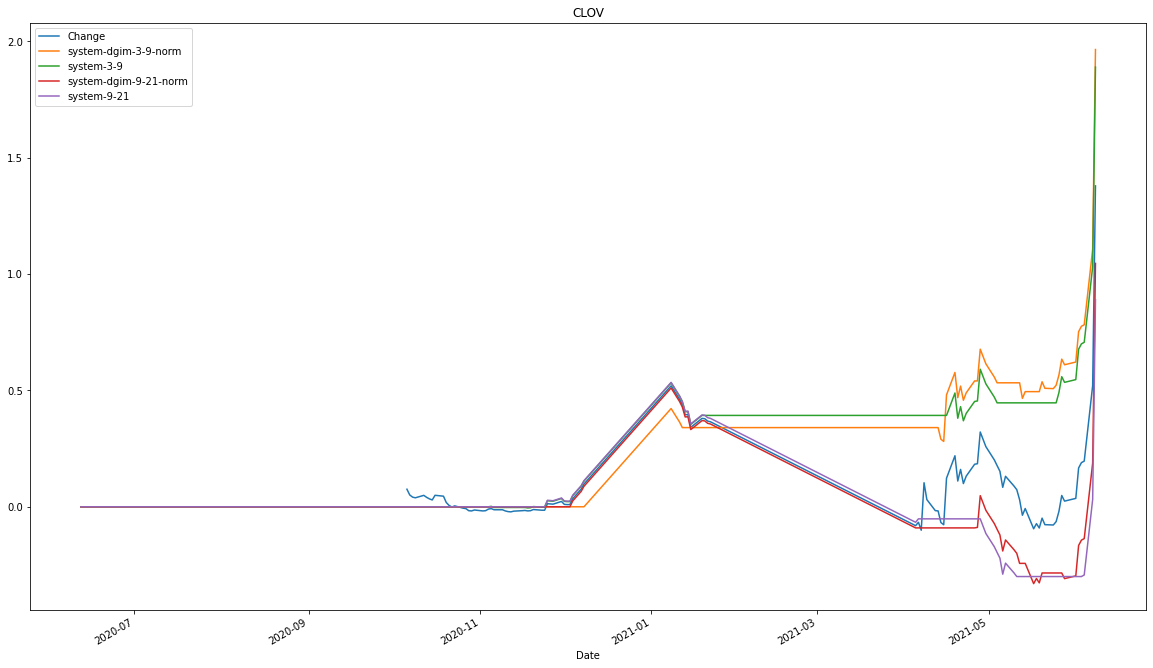

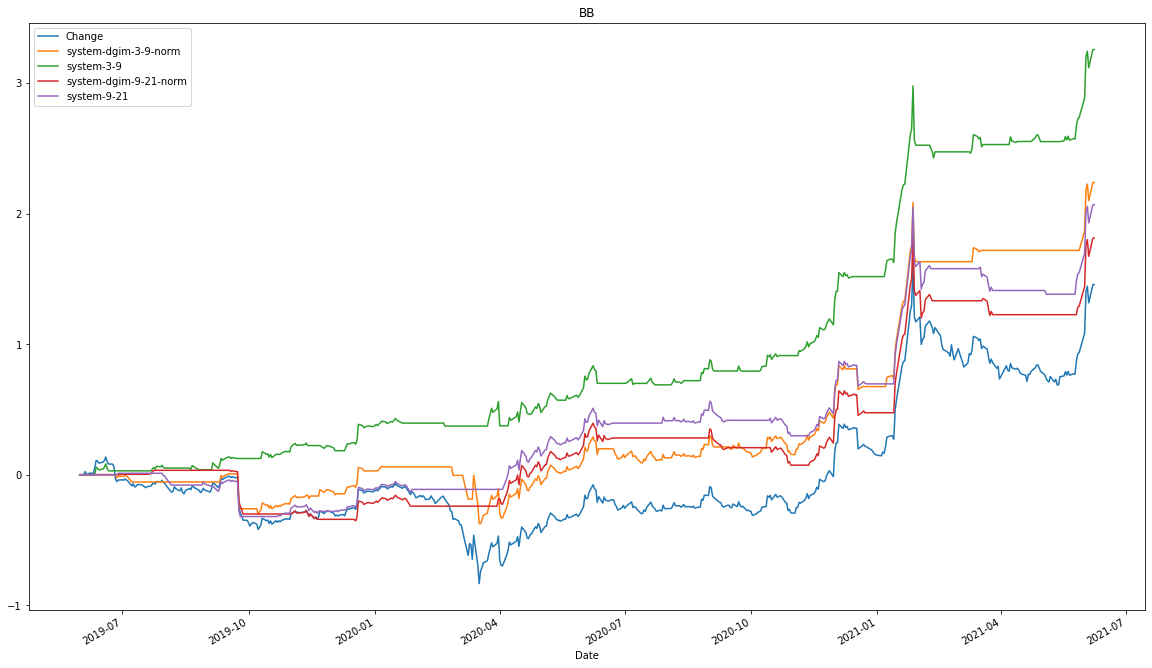

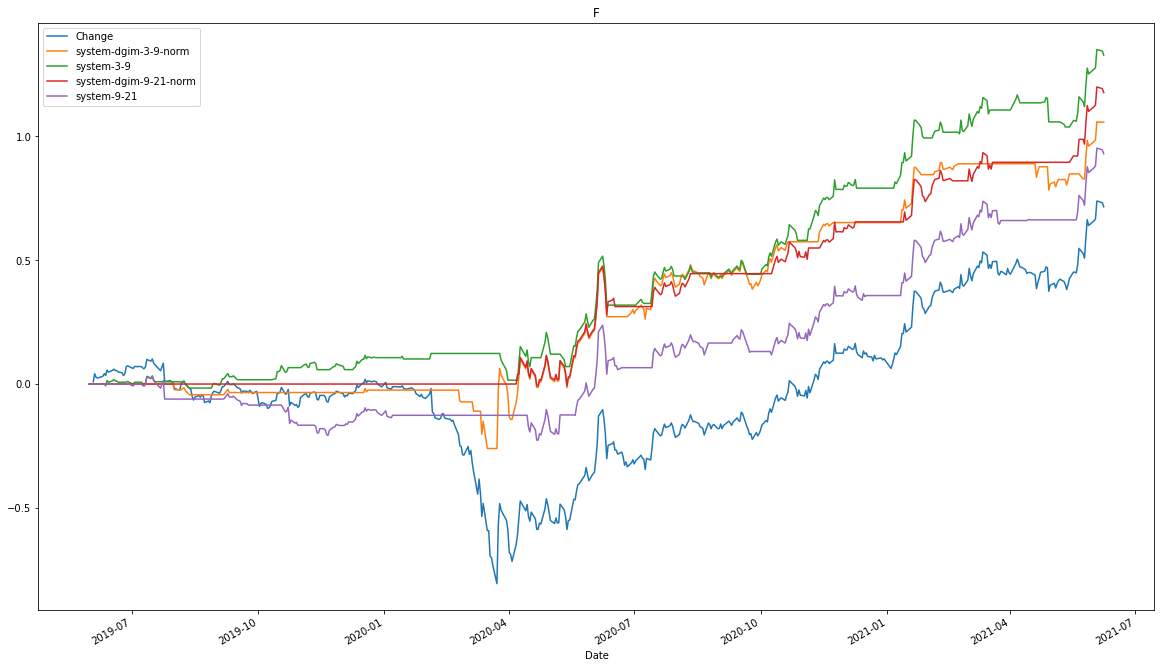

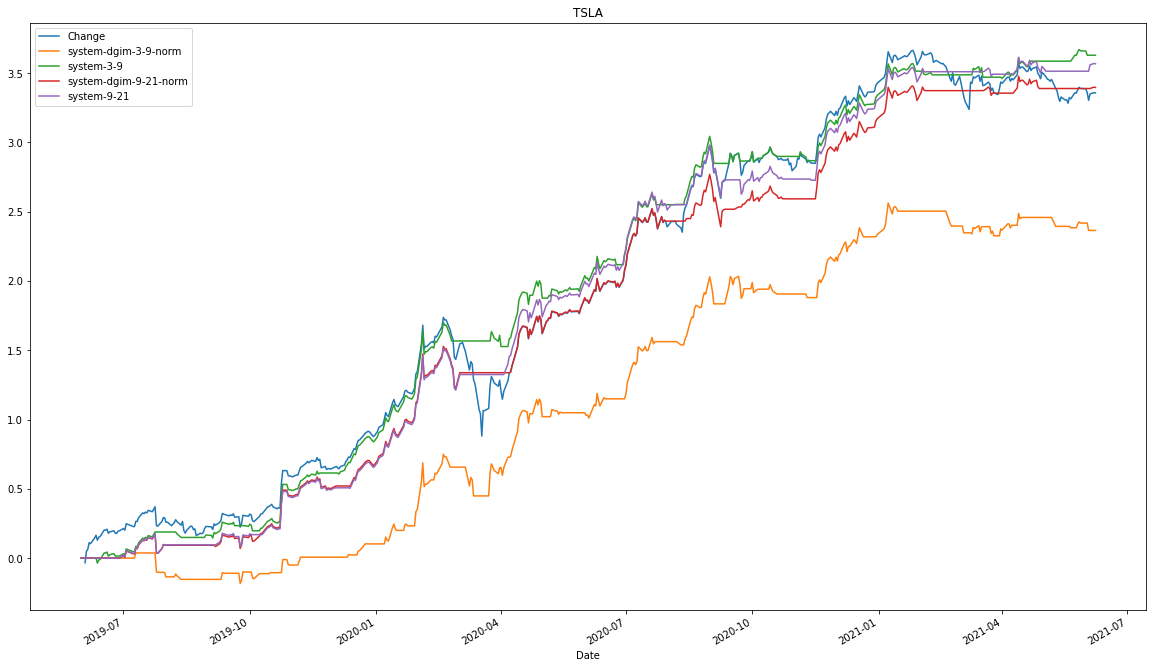

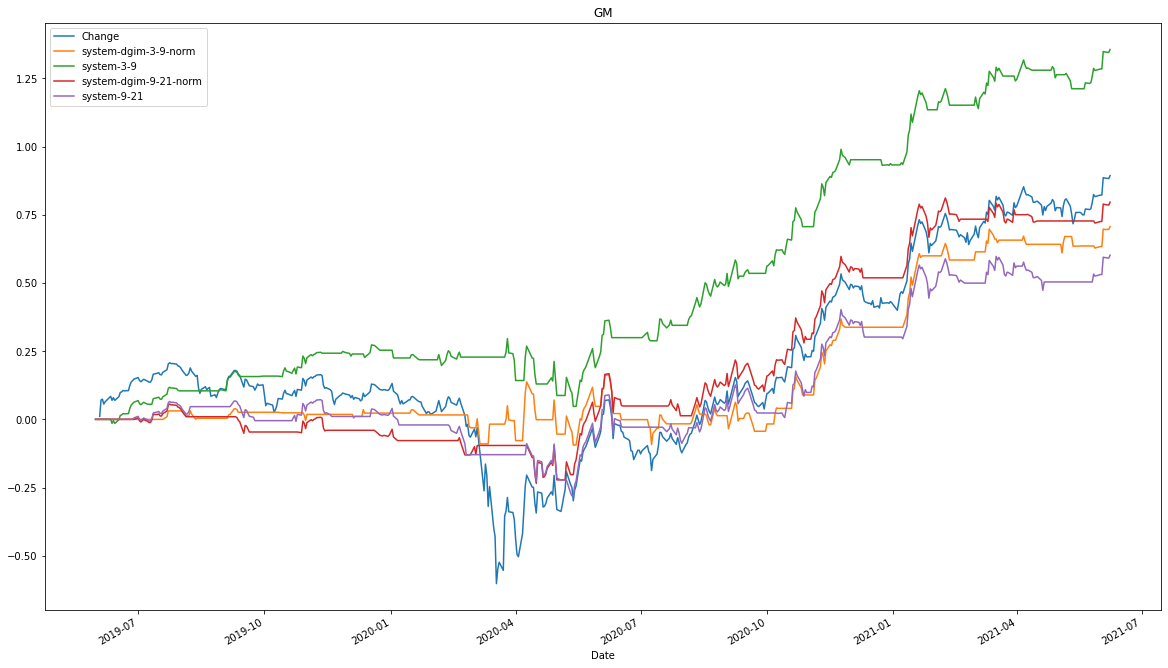

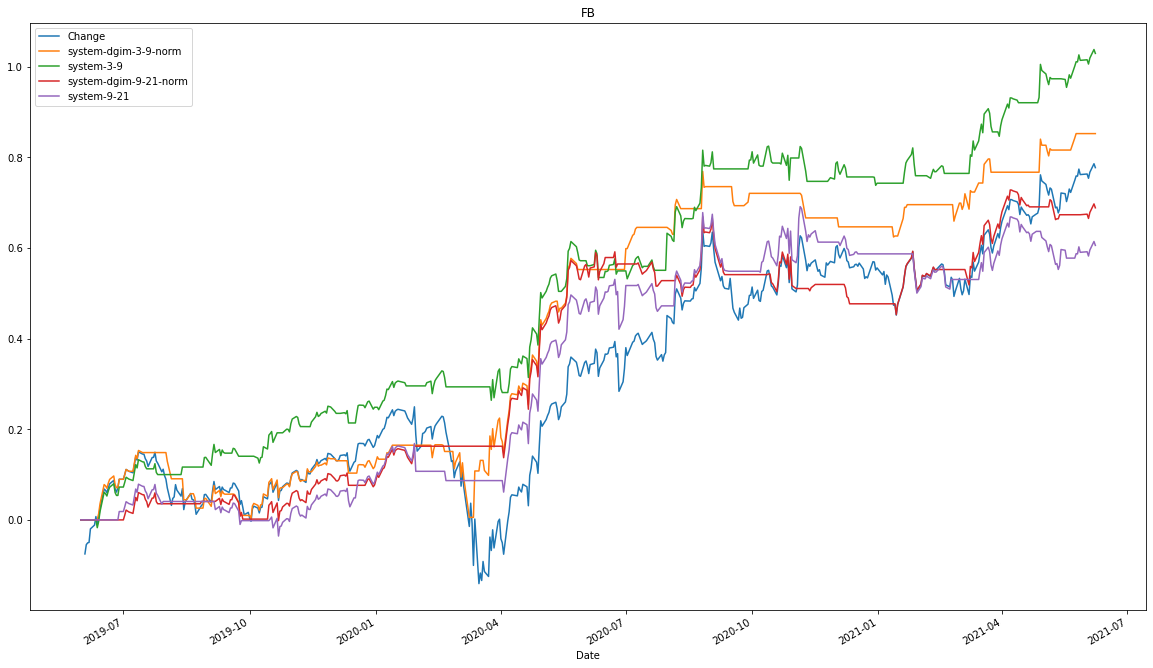

In [6]:
def printSystems(ticker):
    stocks[ticker][['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().plot(title=ticker,figsize=(20,12))

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=printSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## View Accumulated Performance

Change  system-dgim-3-9-norm  system-3-9  \
2021-06-04  54.308970             58.785149   77.689384   
2021-06-05  54.308970             58.785149   77.689384   
2021-06-06  54.308970             58.785149   77.689384   
2021-06-07  55.840987             60.043812   79.129903   
2021-06-08  56.788824             60.976845   80.079811   

            system-dgim-9-21-norm  system-9-21  
2021-06-04              51.553570    48.791139  
2021-06-05              51.553570    48.791139  
2021-06-06              51.553570    48.791139  
2021-06-07              53.118048    50.275842  
2021-06-08              54.043902    51.210494

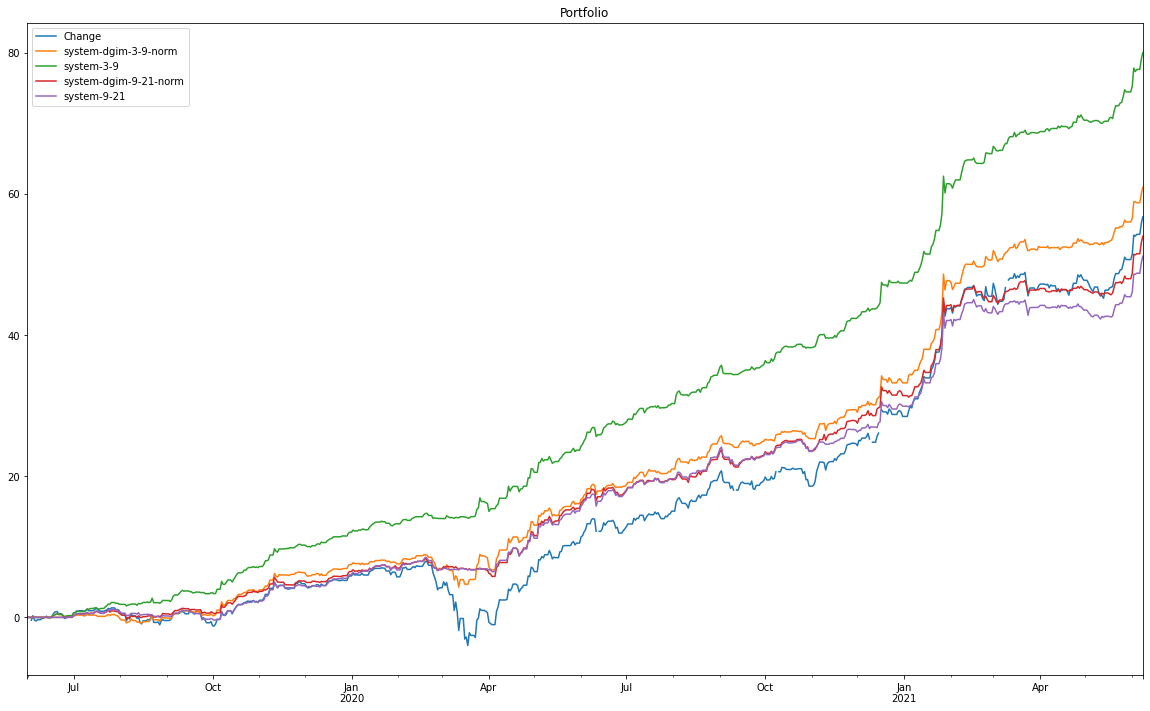

In [7]:
portfolio = 0
for ticker in tickers:
    idx = pd.date_range(date, pd.to_datetime('today'))
    portfolio += stocks[ticker].reindex(idx, fill_value=0)

portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().replace(to_replace=0, method='ffill').plot(title="Portfolio",figsize=(20,12))
portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().tail()

## Generate USD Gain

/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


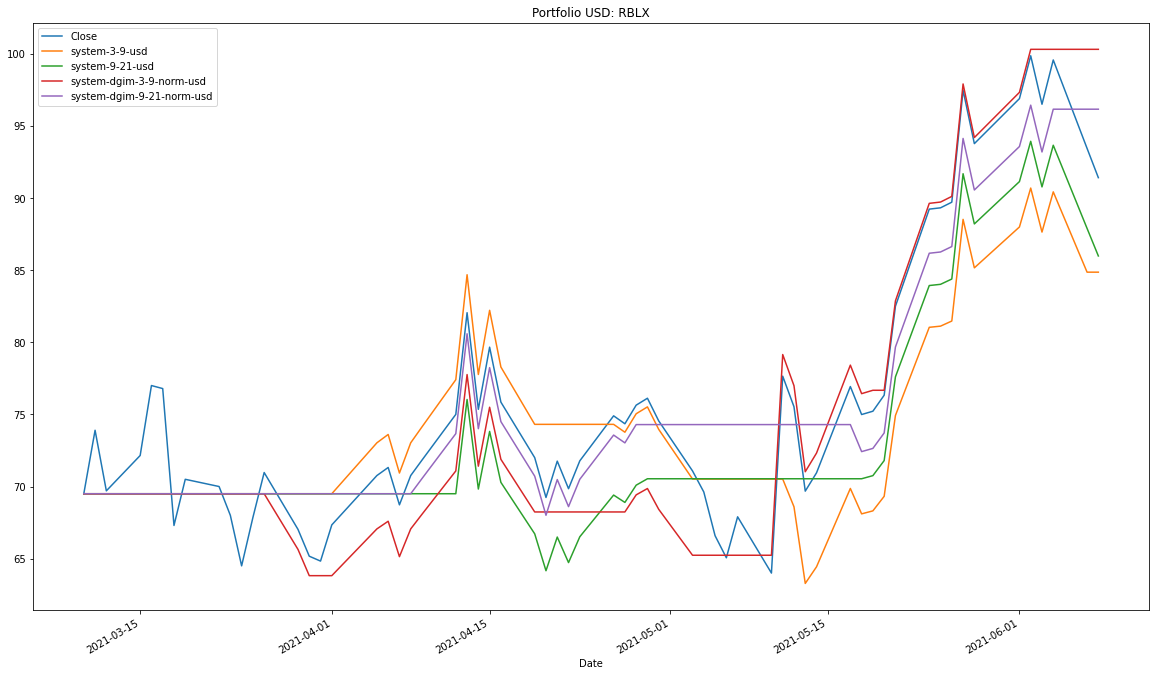

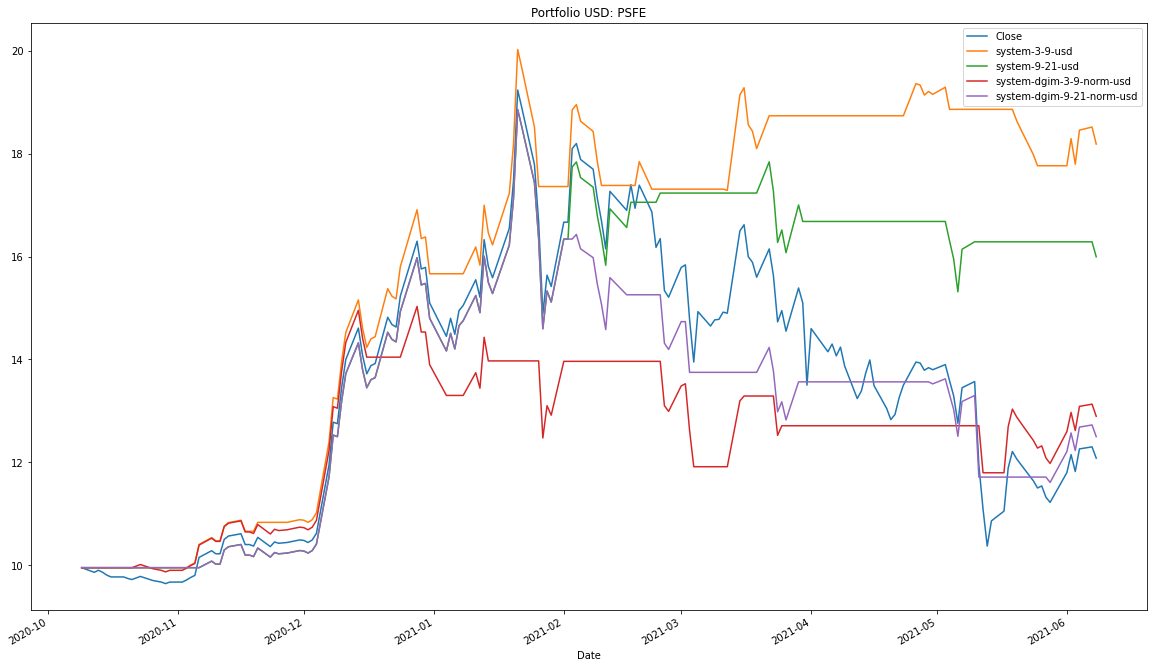

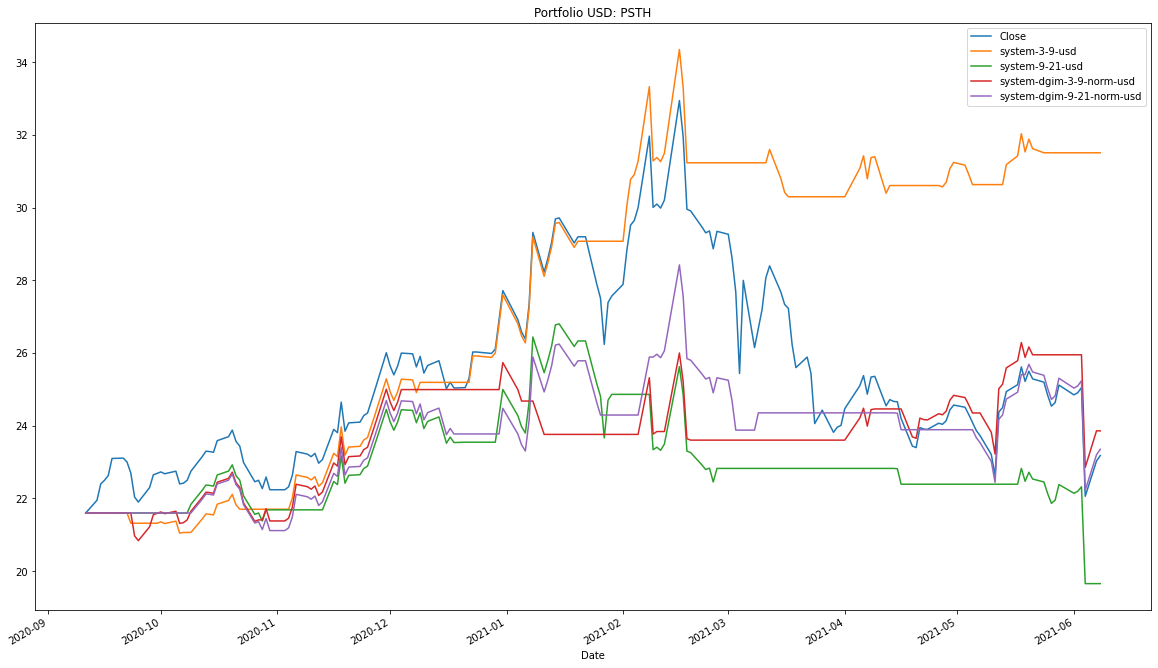

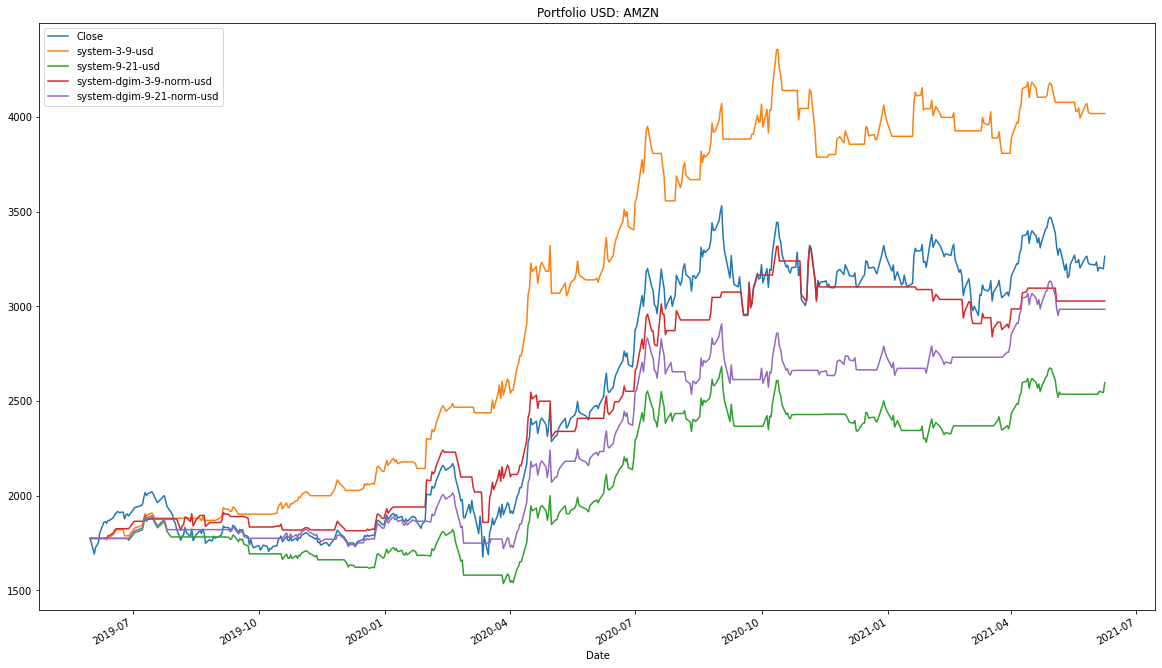

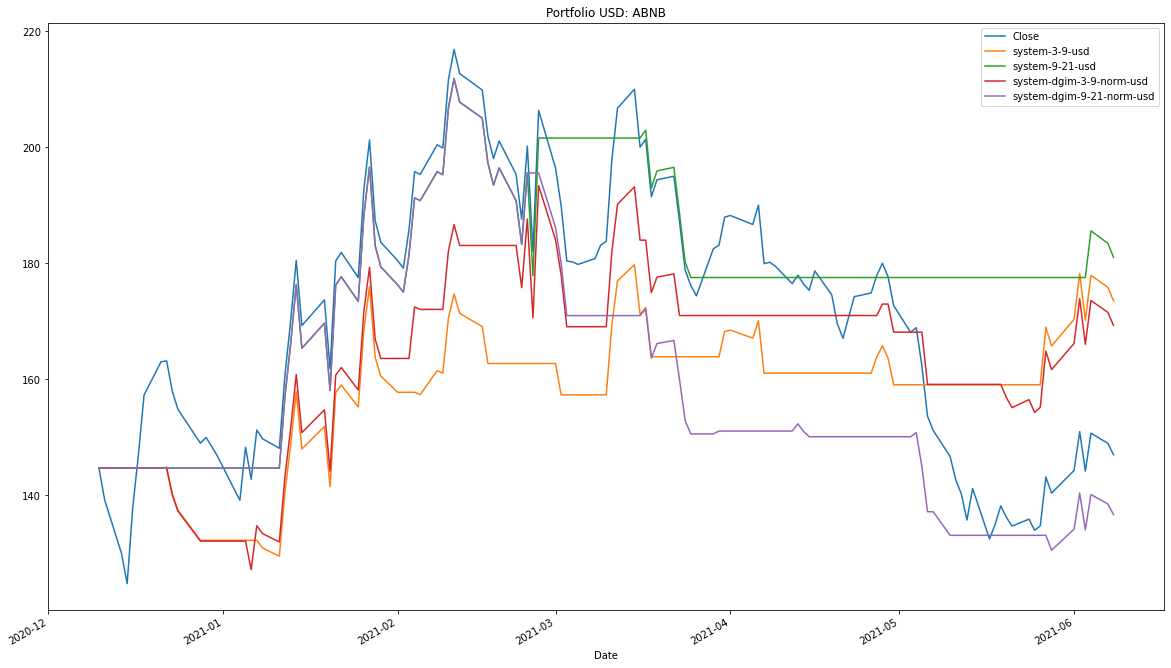

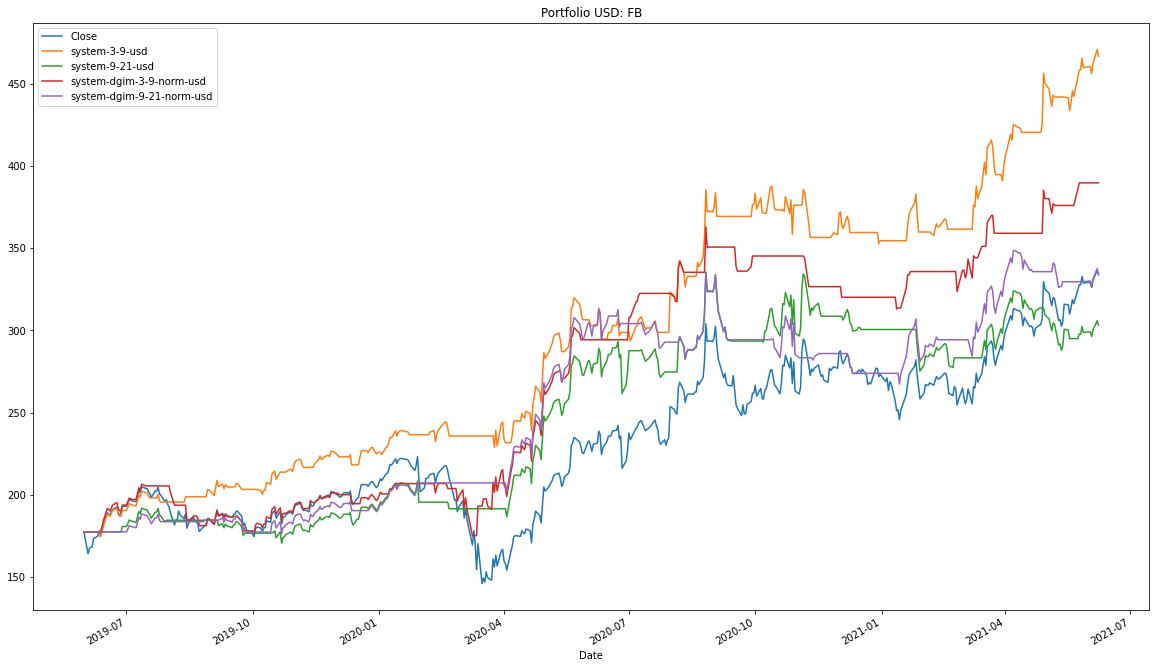

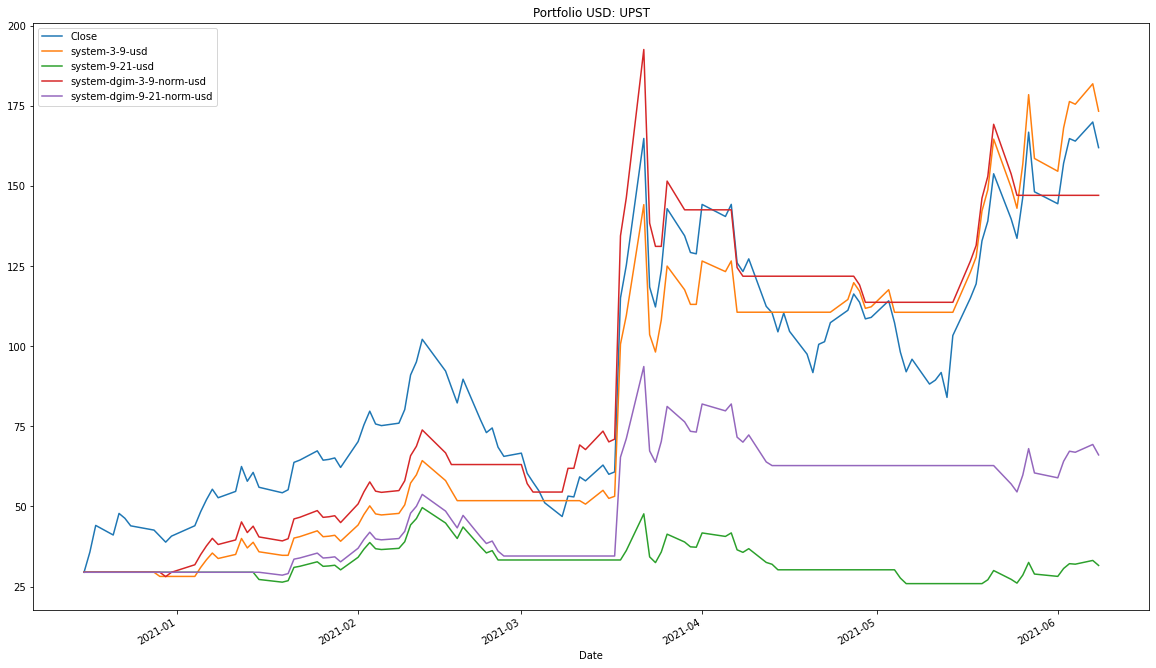

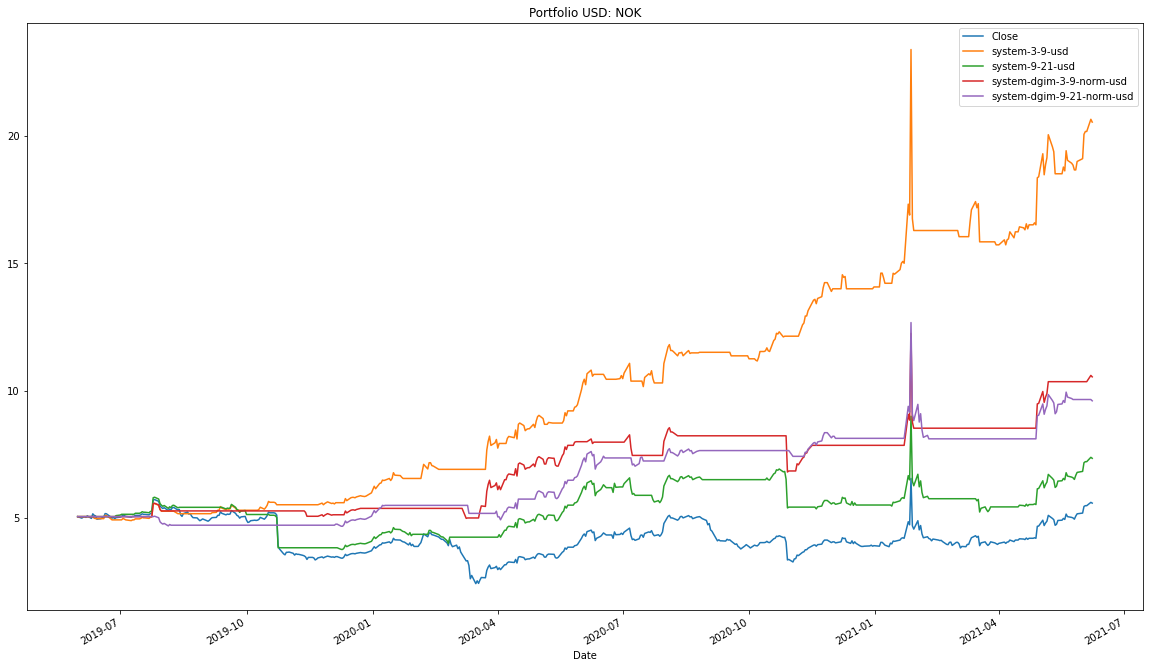

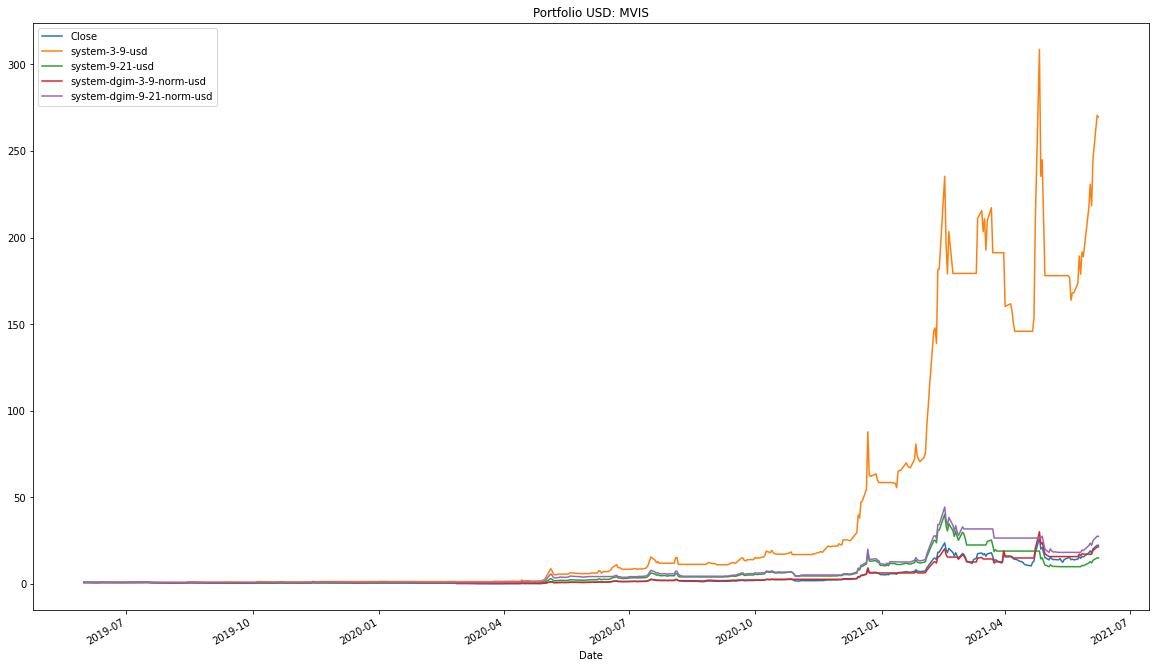

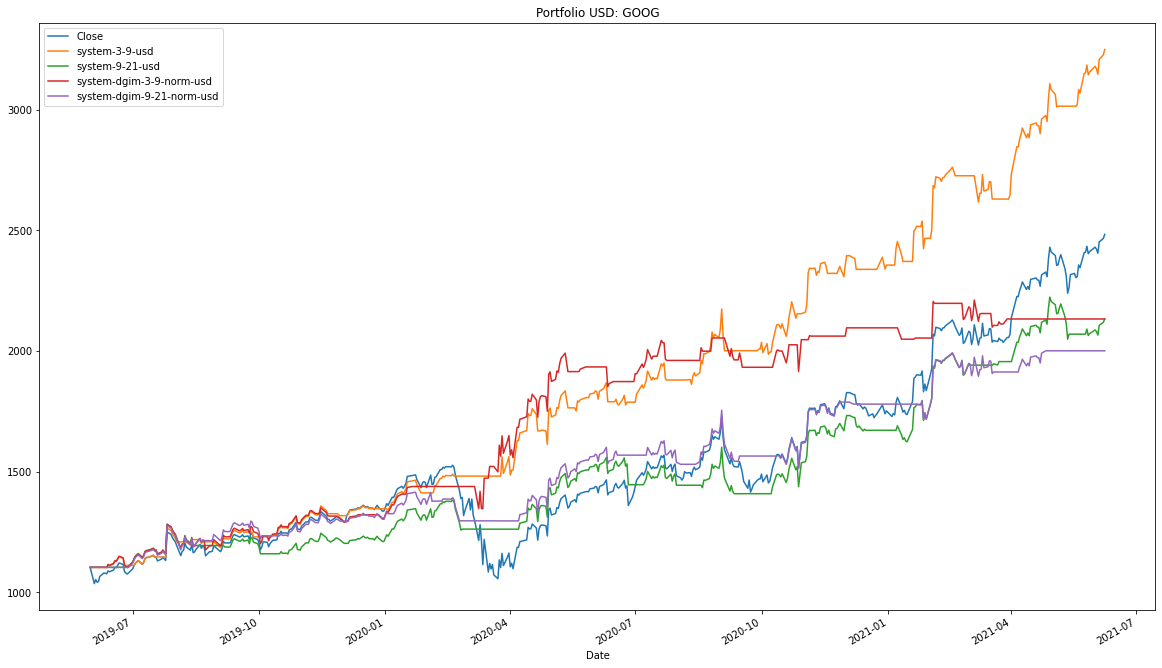

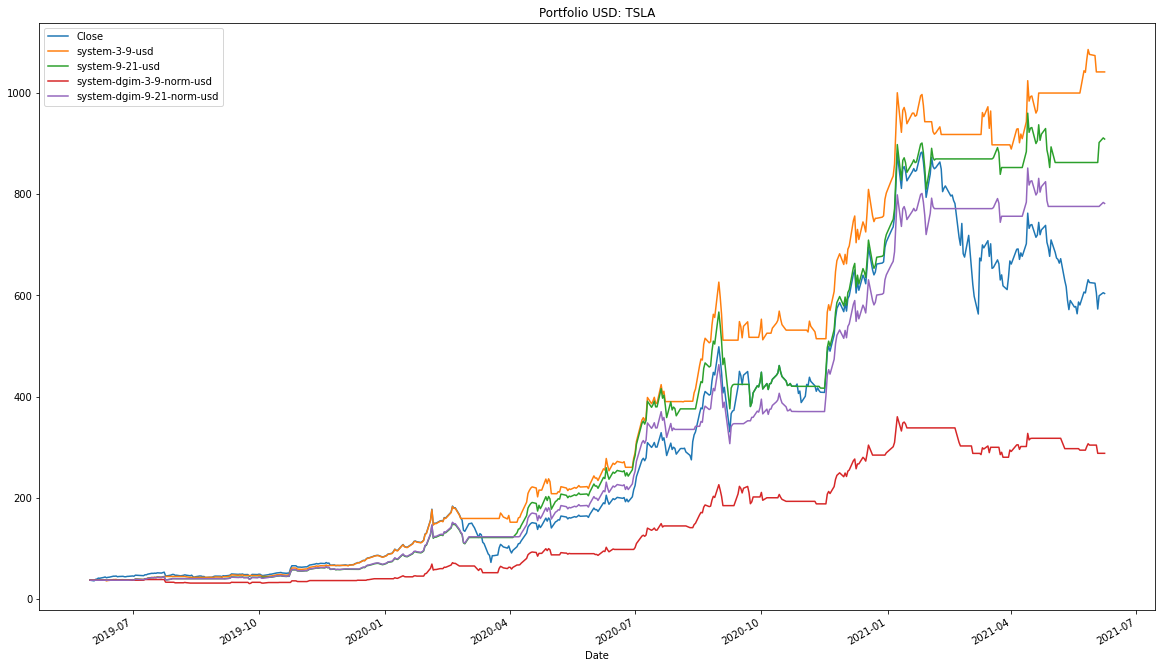

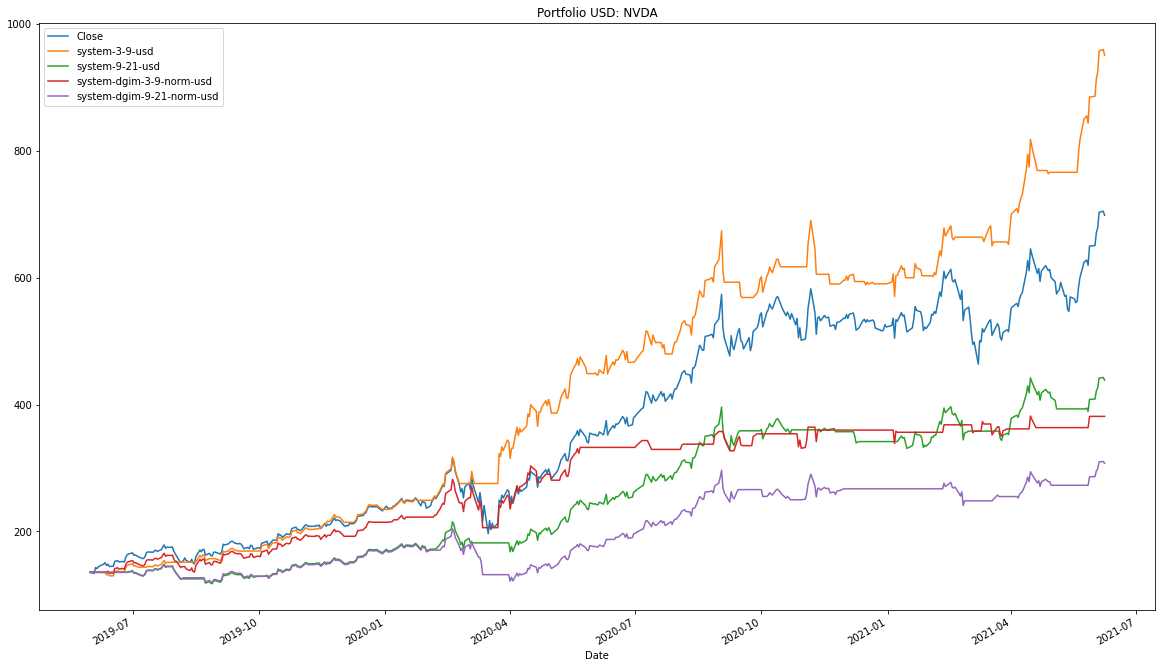

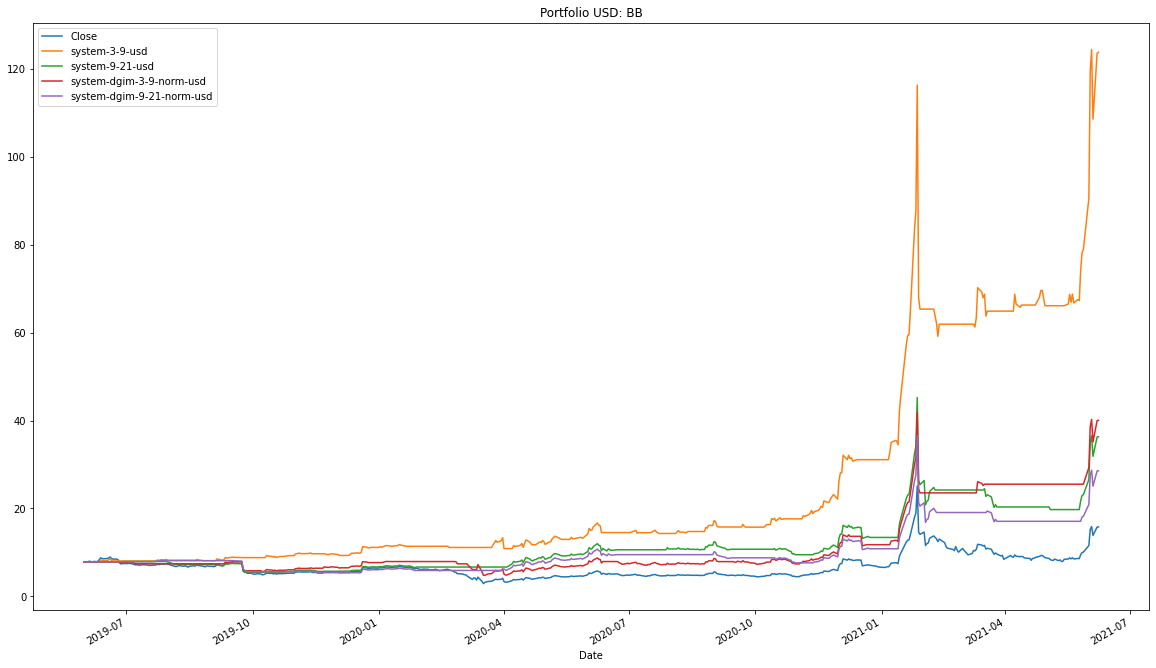

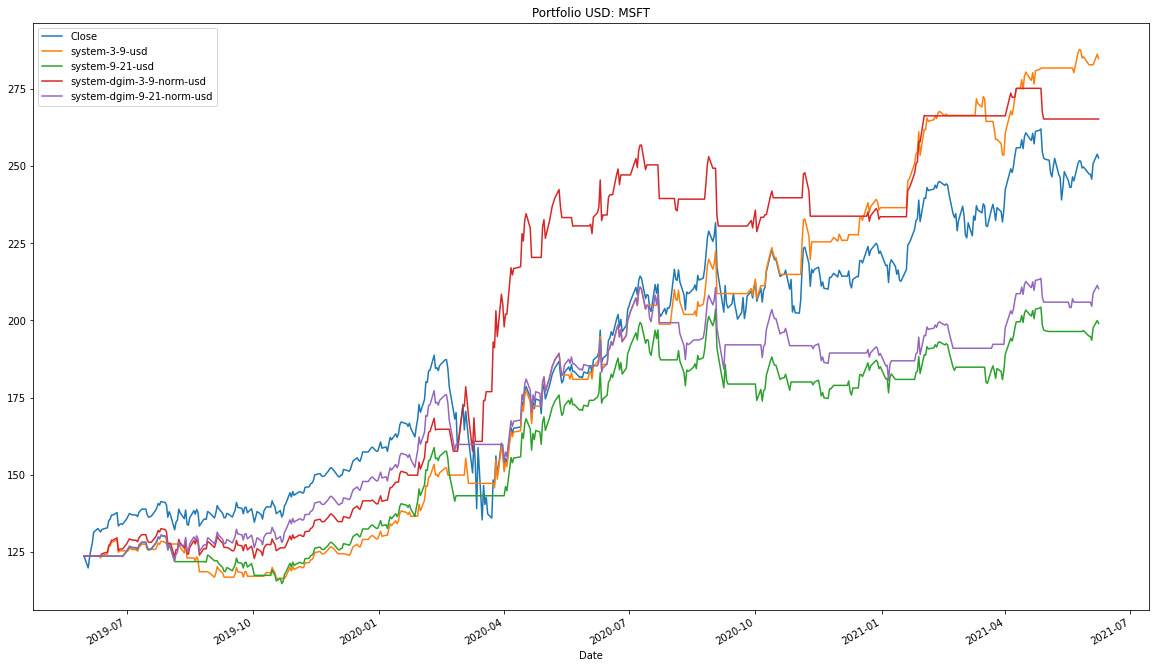

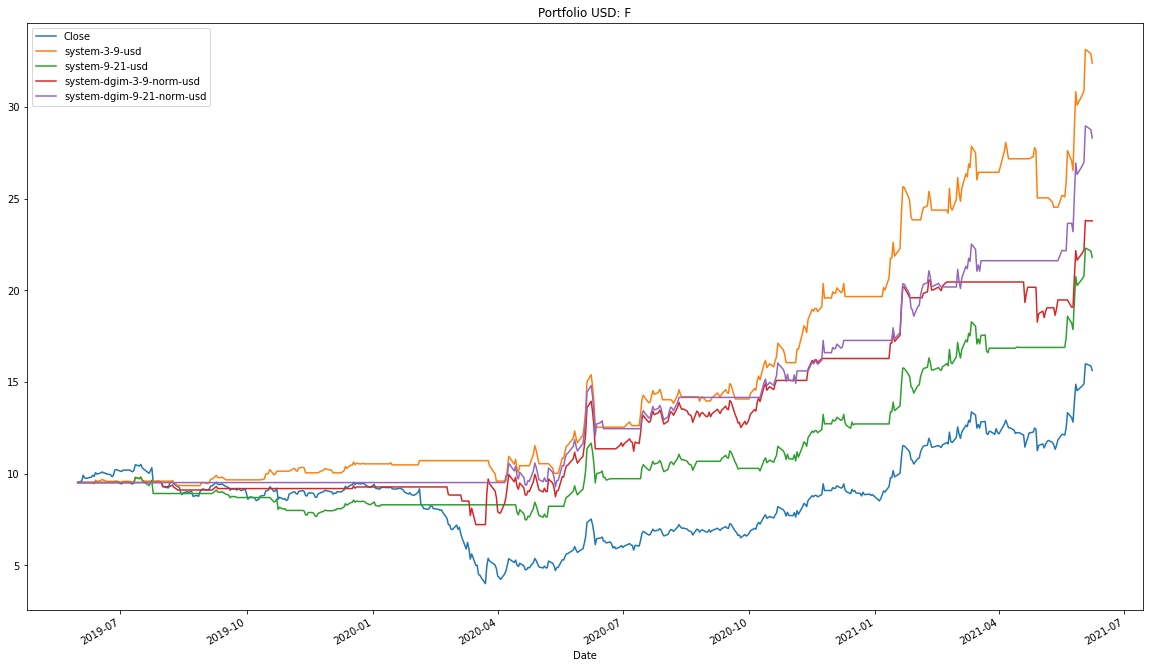

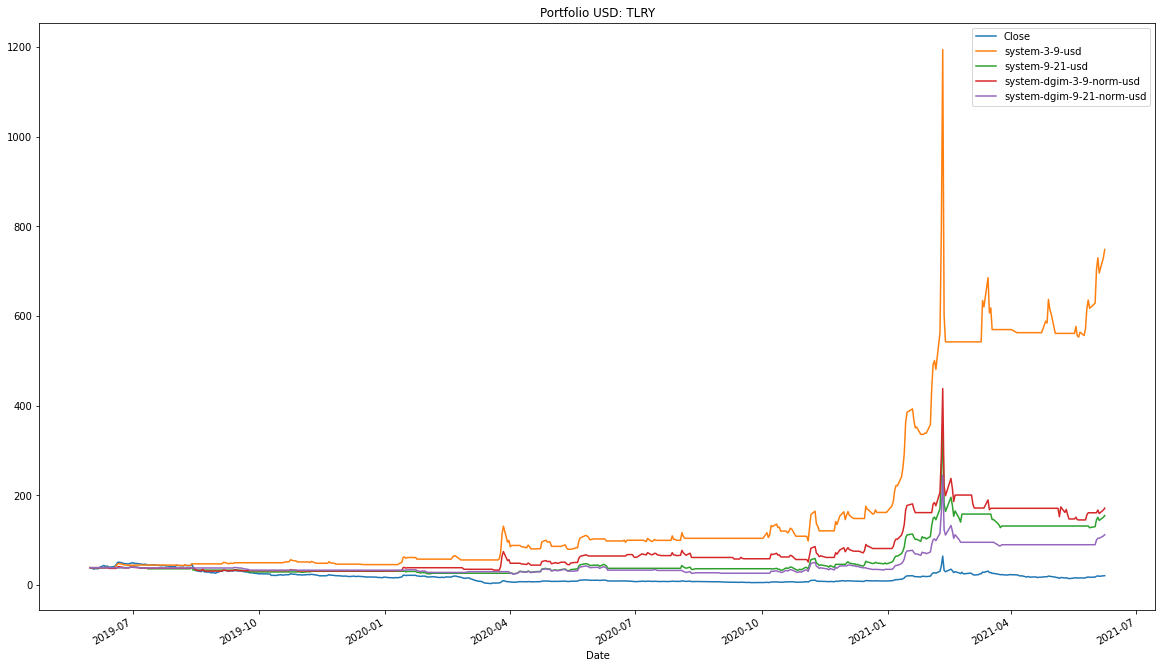

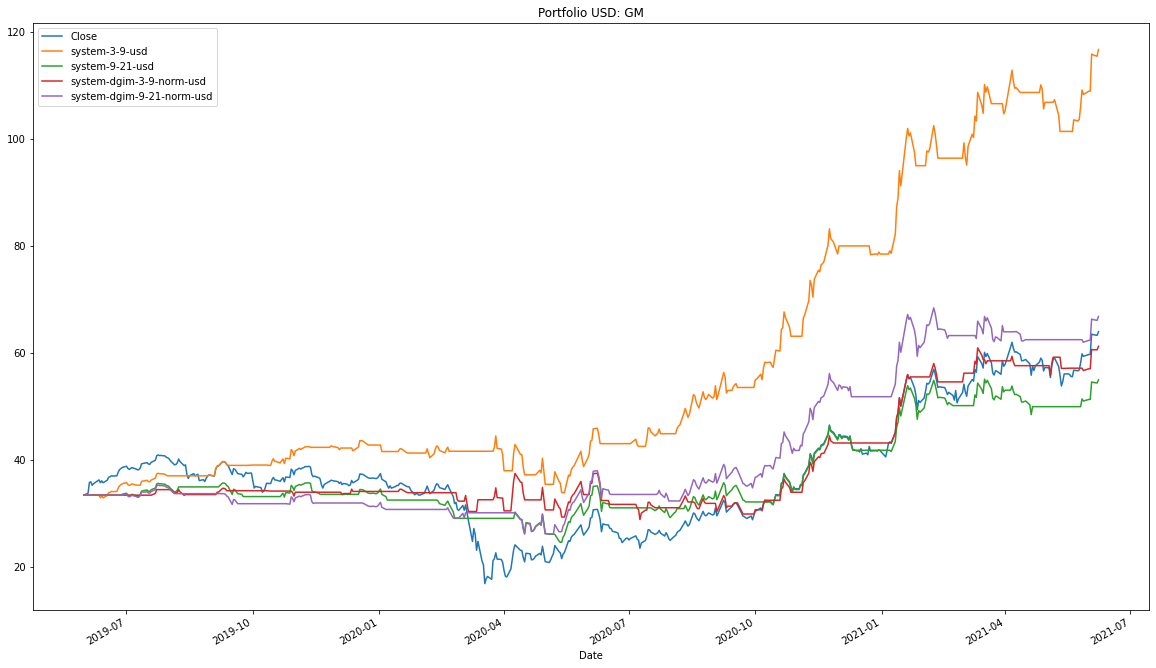

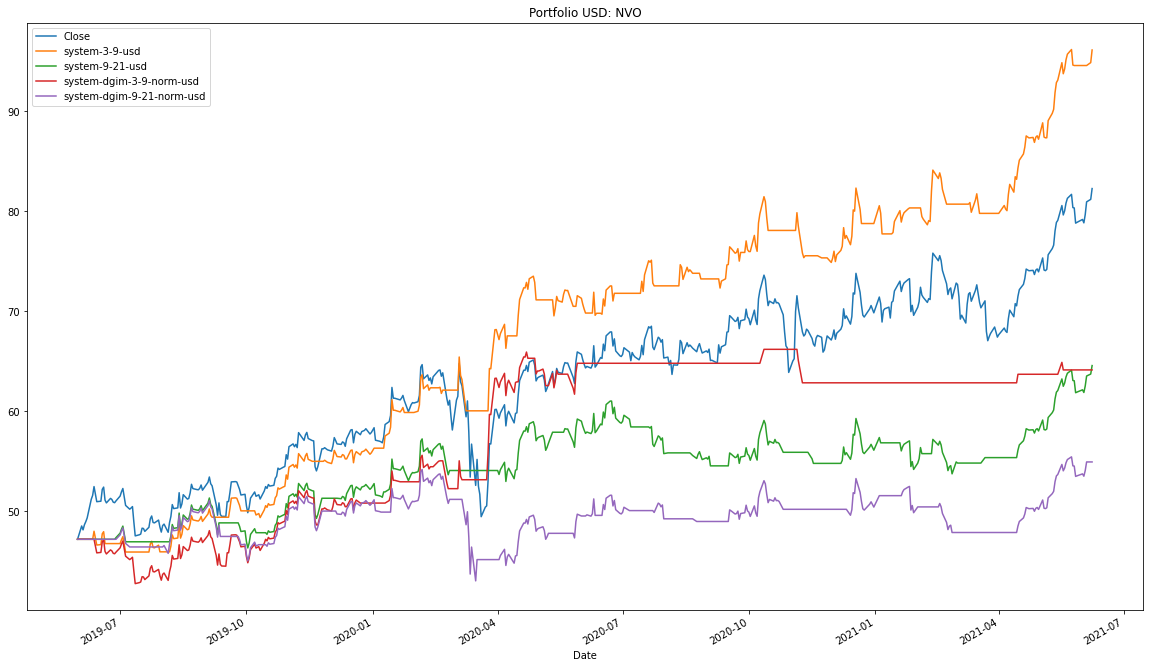

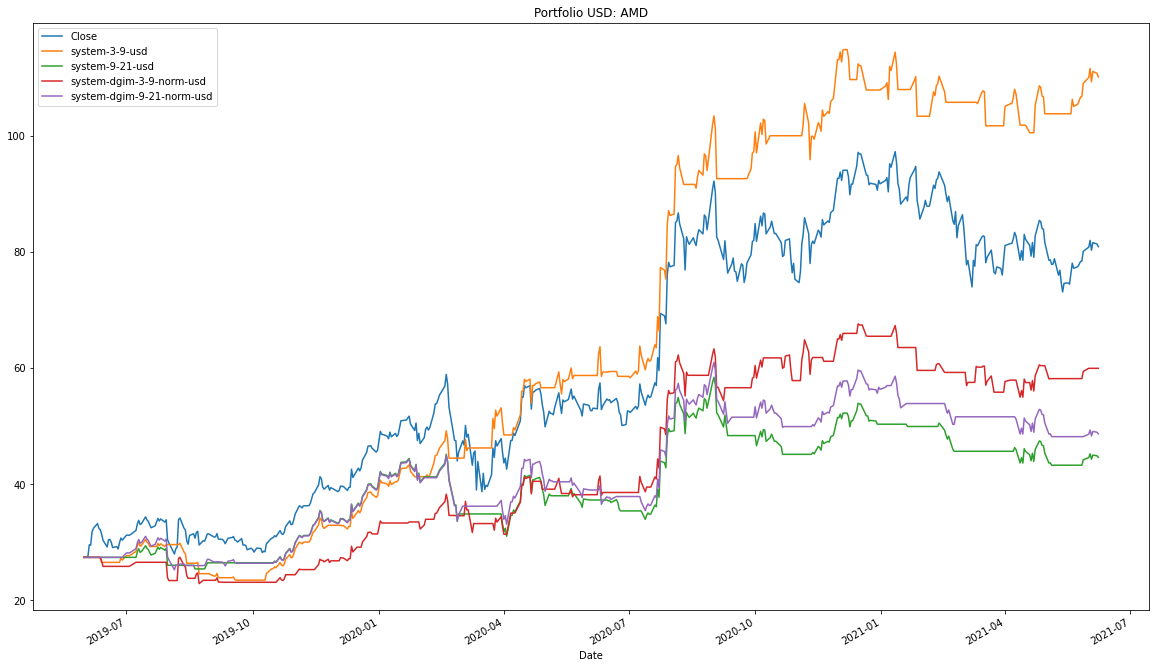

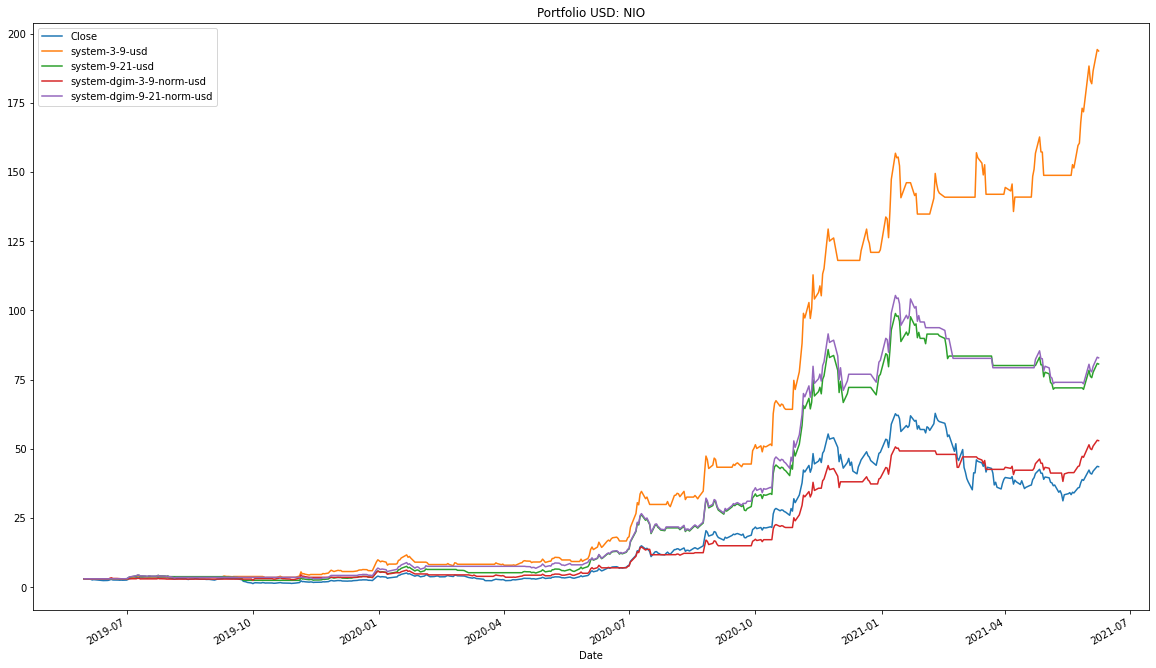

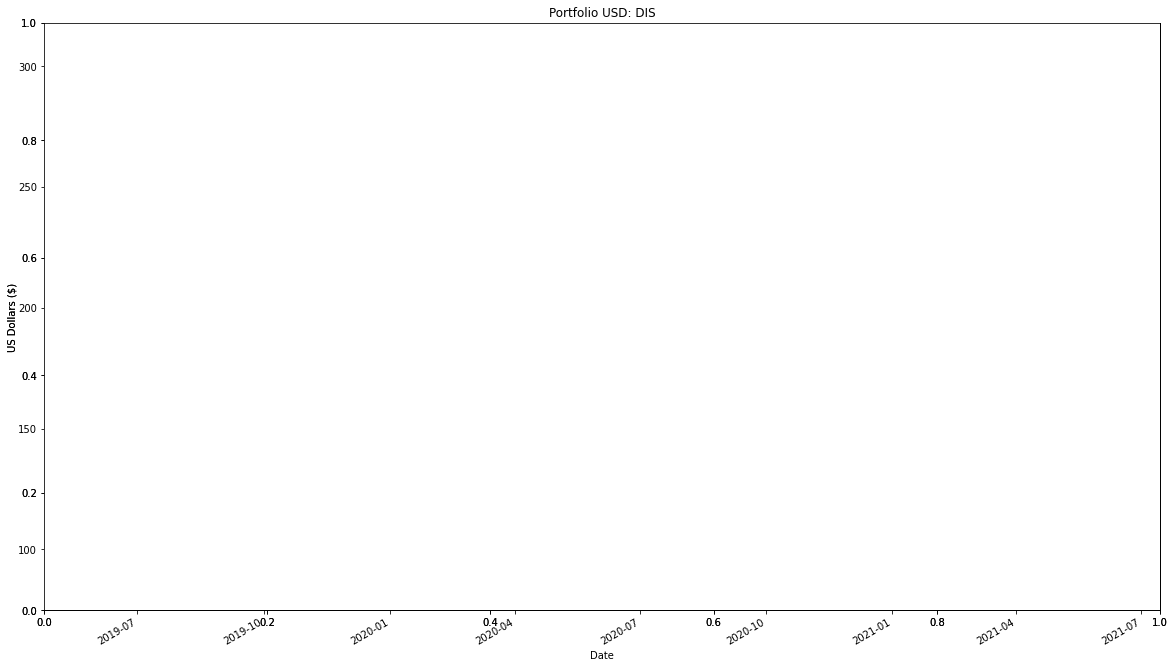

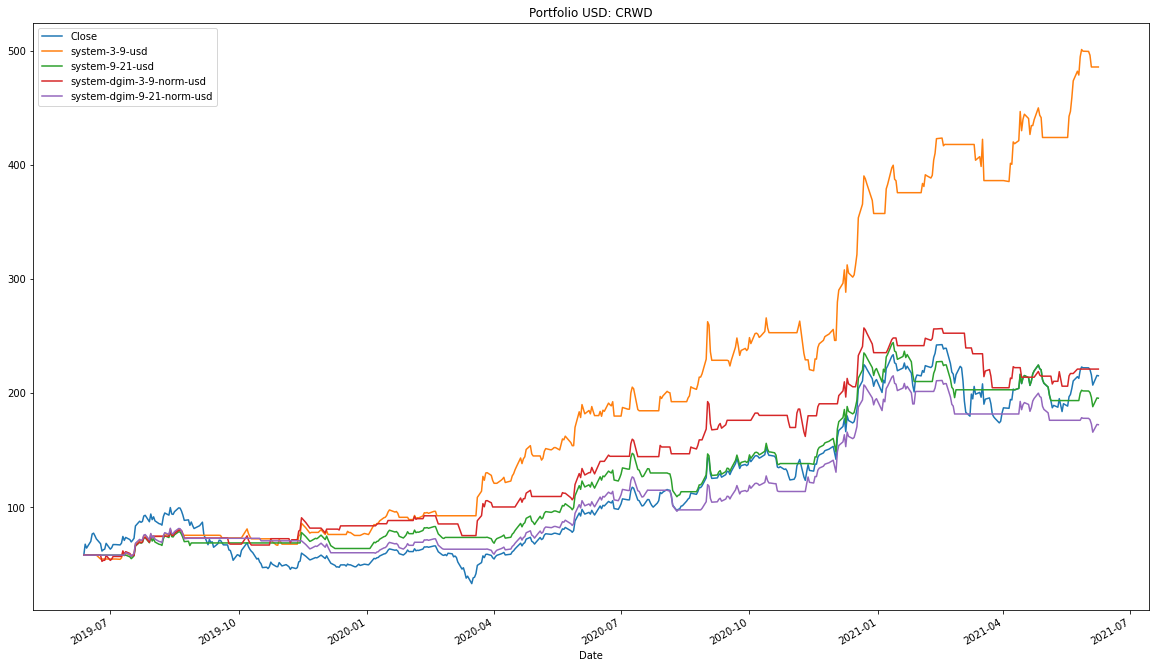

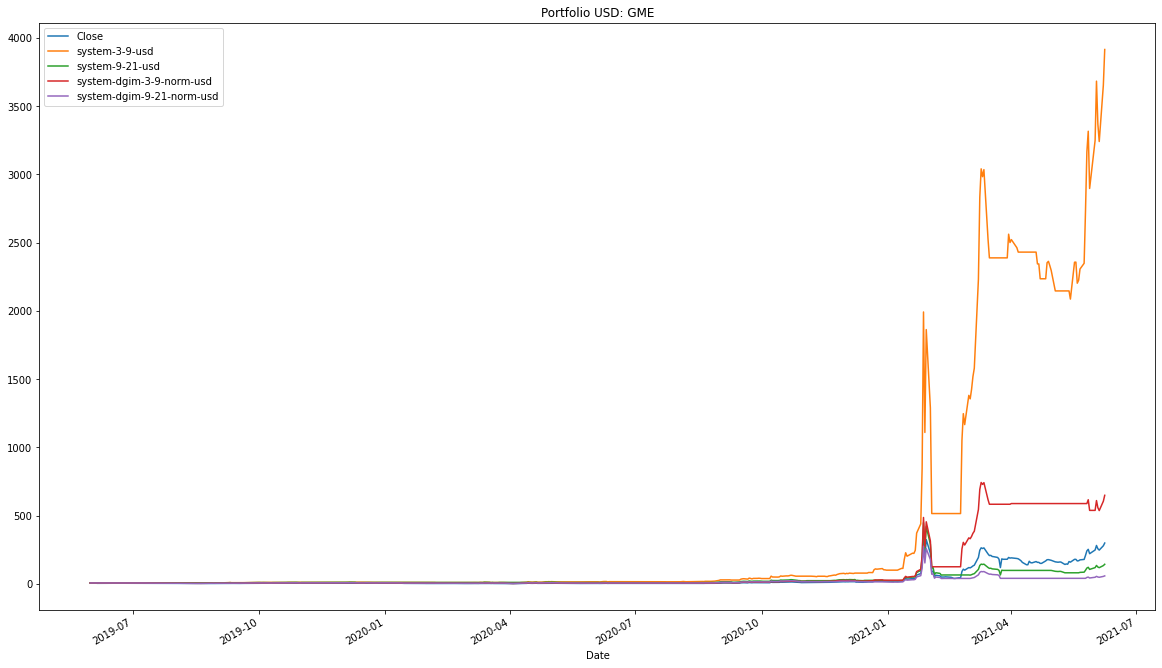

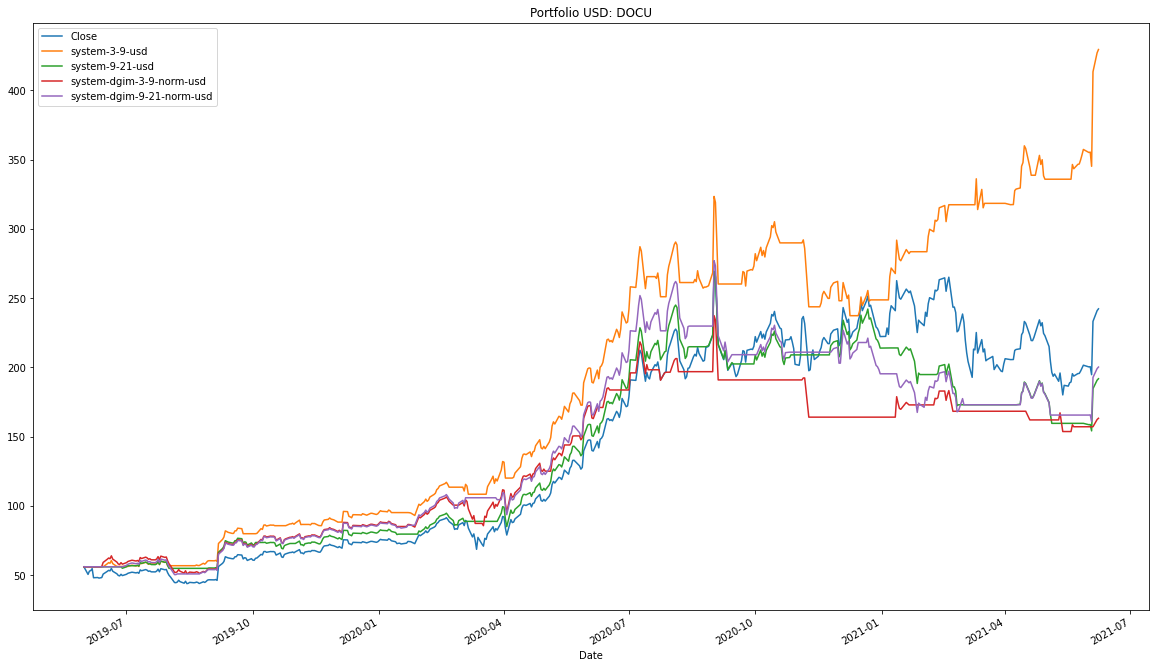

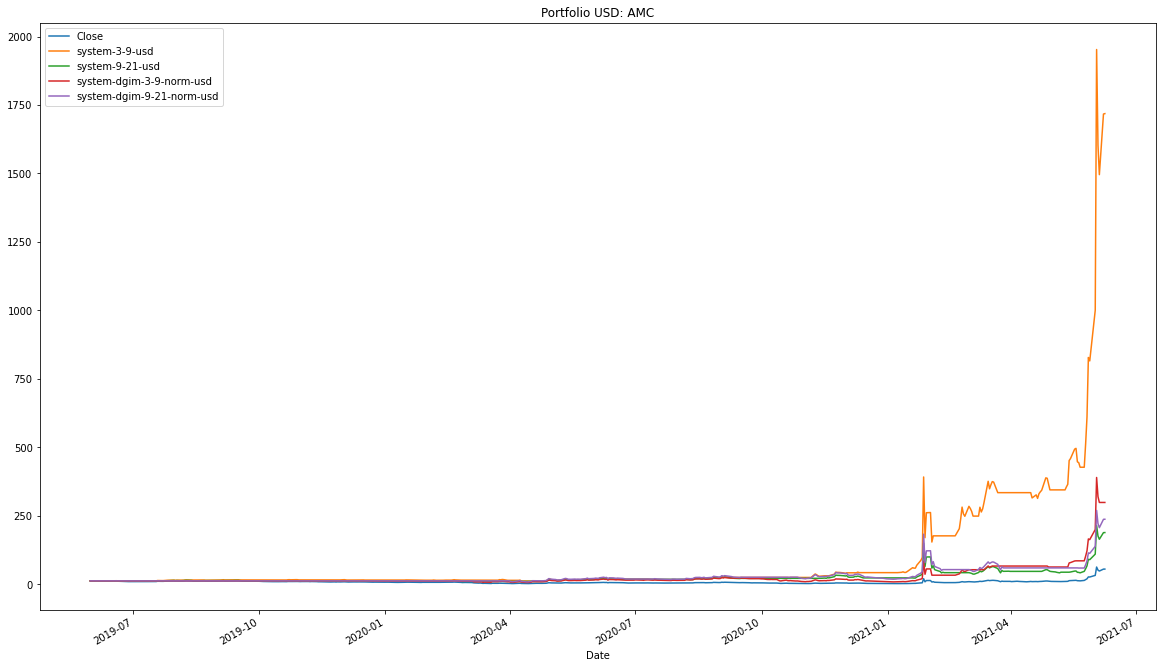

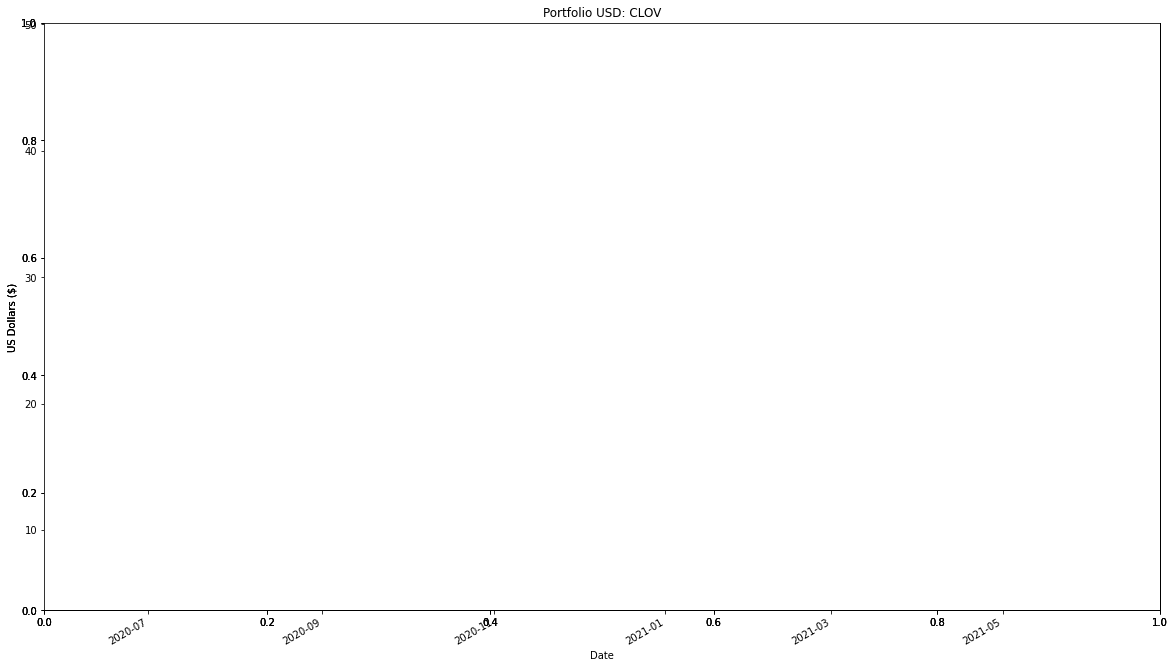

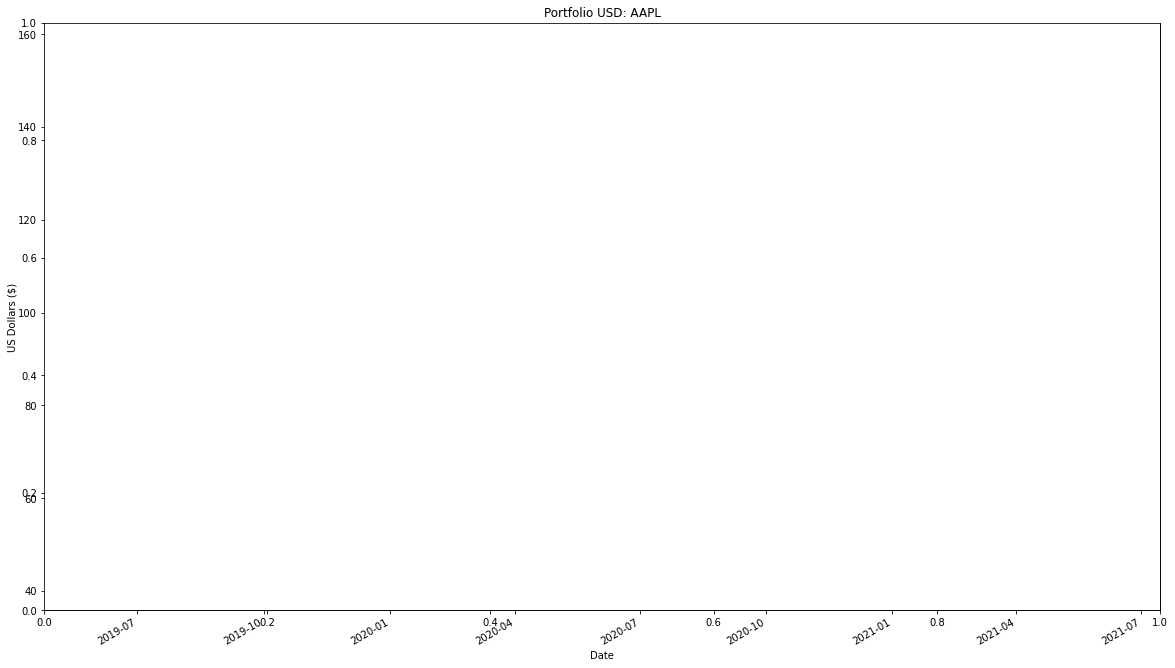

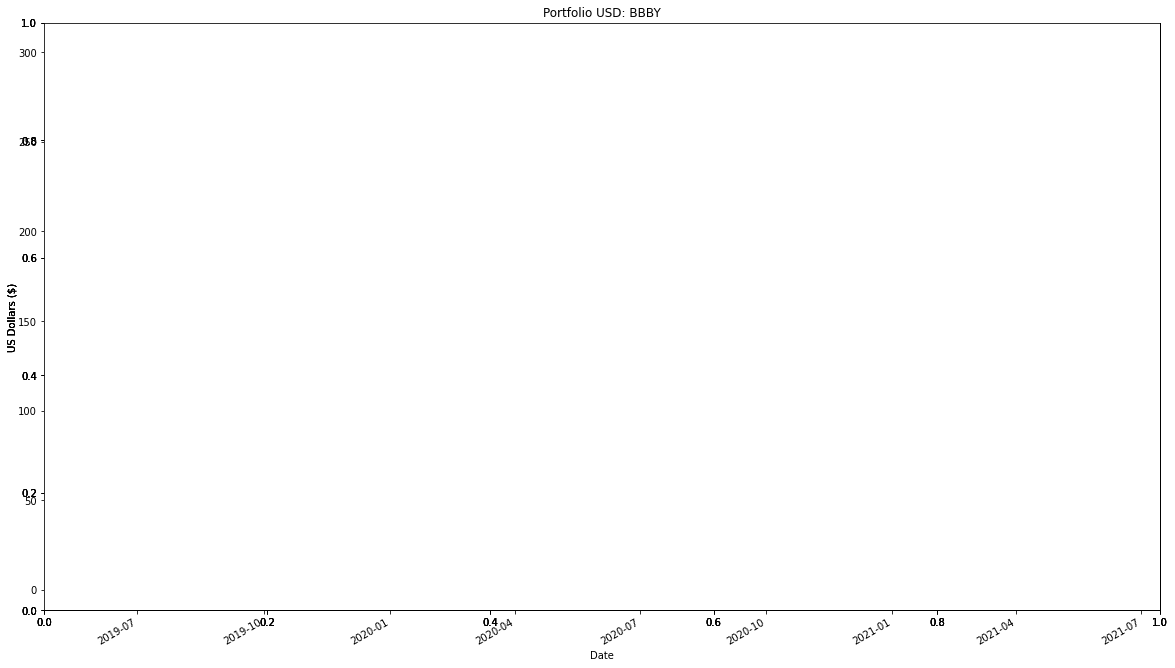

In [8]:
def GenerateUSD(ticker):
    sys39 = [stocks[ticker]['Close'][0]]
    sys921 = [stocks[ticker]['Close'][0]]
    sysdgimnorm39 = [stocks[ticker]['Close'][0]]
    sysdgimnorm921 = [stocks[ticker]['Close'][0]]
    
    for i in range(1,len(stocks[ticker]["Close"])):
        sys39.append(sys39[i-1] * (1+stocks[ticker]["system-3-9"][i]))
        sys921.append(sys921[i-1] * (1+stocks[ticker]["system-9-21"][i]))
        sysdgimnorm39.append(sysdgimnorm39[i-1] * (1+stocks[ticker]["system-dgim-3-9-norm"][i]))
        sysdgimnorm921.append(sysdgimnorm921[i-1] * (1+stocks[ticker]["system-dgim-9-21-norm"][i]))

    stocks[ticker]["system-3-9-usd"] = sys39
    stocks[ticker]["system-9-21-usd"] = sys921
    stocks[ticker]["system-dgim-3-9-norm-usd"] = sysdgimnorm39
    stocks[ticker]["system-dgim-9-21-norm-usd"] = sysdgimnorm921    
    
    stocks[ticker][['Close','system-3-9-usd','system-9-21-usd','system-dgim-3-9-norm-usd','system-dgim-9-21-norm-usd']].fillna(method ='pad').plot(title="Portfolio USD: %s" % ticker,figsize=(20,12))
    plt.ylabel('US Dollars ($)')

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=GenerateUSD, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## View Accumulated Portfolio USD Gains

Close  system-dgim-3-9-norm-usd  system-3-9-usd  \
2021-06-04  9698.529971               9498.803172    19027.727563   
2021-06-05  9698.529971               9498.803172    19027.727563   
2021-06-06  9698.529971               9498.803172    19027.727563   
2021-06-07  9896.920124               9745.883069    20055.169597   
2021-06-08  9990.830254               9813.857611    20375.222886   

            system-dgim-9-21-norm-usd  system-9-21-usd  
2021-06-04                8555.681012      8523.515544  
2021-06-05                8555.681012      8523.515544  
2021-06-06                8555.681012      8523.515544  
2021-06-07                8707.170089      8673.267124  
2021-06-08                8715.209753      8752.961184

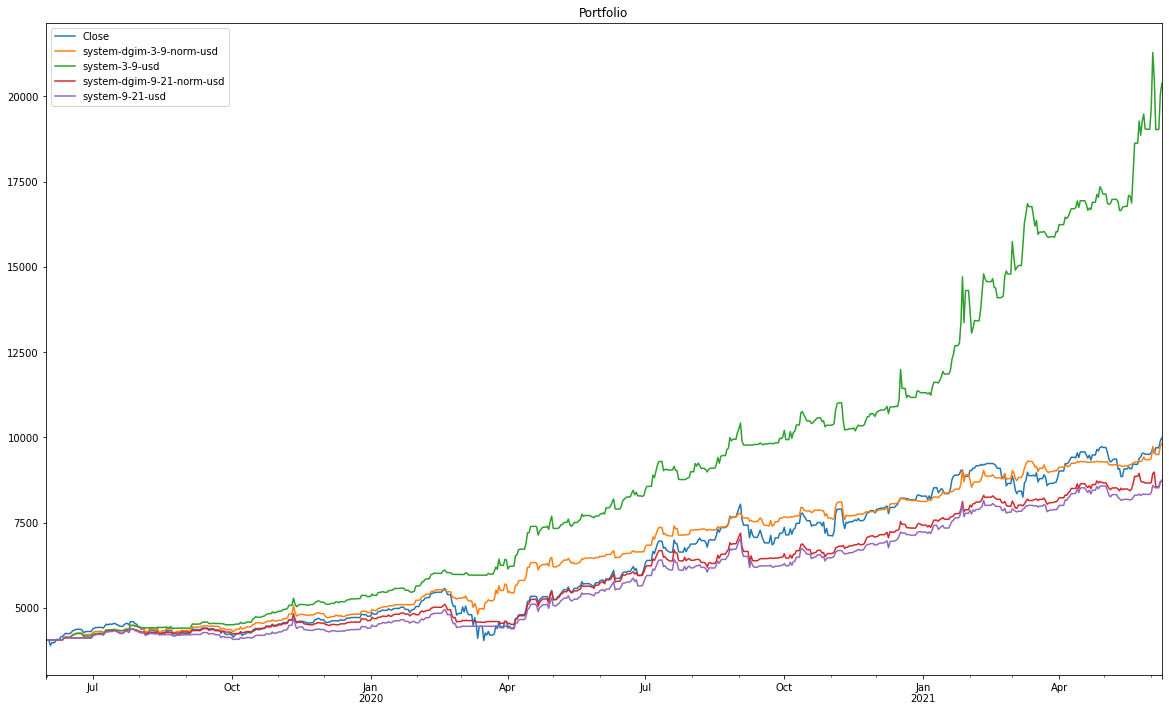

In [9]:
portfolio_usd = 0
for ticker in tickers:
    idx = pd.date_range(date, pd.to_datetime('today'))
    portfolio_usd += stocks[ticker].reindex(idx, fill_value=0)

portfolio_usd[['Close','system-dgim-3-9-norm-usd','system-3-9-usd','system-dgim-9-21-norm-usd','system-9-21-usd']].replace(to_replace=0, method='ffill').plot(title="Portfolio",figsize=(20,12))
portfolio_usd[['Close','system-dgim-3-9-norm-usd','system-3-9-usd','system-dgim-9-21-norm-usd','system-9-21-usd']].replace(to_replace=0, method='ffill').tail()

## Determine Mean Difference for MA and Normalized DGIM MA Performance against Baseline

In [10]:
analysis = []
for ticker in tickers:
    analysis.append({"gain-3-9": stocks[ticker]['system-3-9'].cumsum().tail(1)[0],
                     "gain-9-21": stocks[ticker]['system-9-21'].cumsum().tail(1)[0],
                     "gain-dgim-3-9-norm": stocks[ticker]['system-dgim-3-9-norm'].cumsum().tail(1)[0],
                     "gain-dgim-9-21-norm": stocks[ticker]['system-dgim-9-21-norm'].cumsum().tail(1)[0],
                     "change": stocks[ticker]['Change'].cumsum().tail(1)[0]})
analysisDf = pd.DataFrame(analysis)

meanDifference_3_9 = (analysisDf['gain-3-9'] - analysisDf['change']).mean()
meanDifference_9_21 = (analysisDf['gain-9-21'] - analysisDf['change']).mean()
meanDifference_dgim_3_9_norm = (analysisDf['gain-dgim-3-9-norm'] - analysisDf['change']).mean()
meanDifference_dgim_9_21_norm = (analysisDf['gain-dgim-9-21-norm'] - analysisDf['change']).mean()
print("meanDifference_3_9:",meanDifference_3_9)
print("meanDifference_9_21:", meanDifference_9_21)
print("meanDifference_dgim_3_9_norm:", meanDifference_dgim_3_9_norm)
print("meanDifference_dgim_9_21_norm:", meanDifference_dgim_9_21_norm)

meanDifference_3_9: 0.714040466902737
meanDifference_9_21: -0.24827009403608635
meanDifference_dgim_3_9_norm: 0.07727493782237611
meanDifference_dgim_9_21_norm: -0.15382316844362323


## Determine Winners: Most time spent as maximum USD value

In [11]:
for ticker in tickers:
    winners = []
    for i in range(len(stocks[ticker])):
        
        day_3_9 = stocks[ticker]["system-3-9-usd"][i]
        day_9_21 = stocks[ticker]["system-9-21-usd"][i]
        day_dgim_3_9_norm = stocks[ticker]["system-dgim-3-9-norm-usd"][i]
        day_dgim_9_21_norm = stocks[ticker]["system-dgim-9-21-norm-usd"][i]
    
        top = max(day_3_9,day_9_21,day_dgim_3_9_norm,day_dgim_9_21_norm)
        if top == day_3_9:
            winners.append("system-3-9-usd")
        elif top == day_9_21:
            winners.append("system-9-21-usd")
        elif top == day_dgim_3_9_norm:
            winners.append("system-dgim-3-9-norm-usd")
        elif top == day_dgim_9_21_norm:
            winners.append("system-dgim-9-21-norm-usd")
    
    day_3_9_percent = 100*winners.count("system-3-9-usd")/len(winners)
    day_9_21_percent = 100*winners.count("system-9-21-usd")/len(winners)
    day_dgim_3_9_norm_percent = 100*winners.count("system-dgim-3-9-norm-usd")/len(winners)
    day_dgim_9_21_norm_percent = 100*winners.count("system-dgim-9-21-norm-usd")/len(winners)
    print(ticker)
    print("system-3-9-usd: %0.2f%%, system-9-21-usd: %0.2f%%, system-dgim-3-9-norm-usd: %0.2f%%, system-dgim-9-21-norm-usd: %0.2f%%" % (day_3_9_percent, day_9_21_percent, day_dgim_3_9_norm_percent, day_dgim_9_21_norm_percent))
    print("Winner: %s" % max(winners,key=winners.count))
    print()

PSFE
system-3-9-usd: 98.80%, system-9-21-usd: 0.00%, system-dgim-3-9-norm-usd: 1.20%, system-dgim-9-21-norm-usd: 0.00%
Winner: system-3-9-usd

RBLX
system-3-9-usd: 57.14%, system-9-21-usd: 0.00%, system-dgim-3-9-norm-usd: 28.57%, system-dgim-9-21-norm-usd: 14.29%
Winner: system-3-9-usd

FB
system-3-9-usd: 83.92%, system-9-21-usd: 0.20%, system-dgim-3-9-norm-usd: 13.33%, system-dgim-9-21-norm-usd: 2.55%
Winner: system-3-9-usd

PSTH
system-3-9-usd: 86.56%, system-9-21-usd: 11.29%, system-dgim-3-9-norm-usd: 2.15%, system-dgim-9-21-norm-usd: 0.00%
Winner: system-3-9-usd

AMZN
system-3-9-usd: 95.29%, system-9-21-usd: 0.20%, system-dgim-3-9-norm-usd: 4.51%, system-dgim-9-21-norm-usd: 0.00%
Winner: system-3-9-usd

ABNB
system-3-9-usd: 8.13%, system-9-21-usd: 91.06%, system-dgim-3-9-norm-usd: 0.00%, system-dgim-9-21-norm-usd: 0.81%
Winner: system-9-21-usd

MVIS
system-3-9-usd: 96.67%, system-9-21-usd: 2.94%, system-dgim-3-9-norm-usd: 0.00%, system-dgim-9-21-norm-usd: 0.39%
Winner: system-3-9-u